# Squirrel Box Visit & Nut Counter (Video + RFID)

This notebook implements an end-to-end workflow to **synchronize RFID sensor events with box videos** and to compute:

- **Time spent in the box per squirrel**
- **Number of nuts taken per squirrel** (via YOLO classes such as `cup_full` / `cup_empty` or `nut`)
- An **overlay video** for fast review
- **CSV tables** for downstream analysis

## Inputs

1. **MP4 videos** recorded at the box (all video files in the `input/` folder are automatically discovered and processed as one continuous recording).
2. **RFID Excel file (.xlsx)** with at least these columns (example):

| study_site | box_nr | ID | name | sex | date | time | unit_nr |
|---|---:|---|---|---|---|---|---:|
| trep_s | 1 | 000815E3CB | Stitch | male | 02.10.2024 | 10:48:54 | 1 |

3. **YOLO weights** (`best.pt`) trained to detect at least the class `squirrel`
   (optionally also `cup_full`, `cup_empty`, and/or `nut`).

## High-level pipeline

1. Discover all video files from the input folder and downscale them.
2. Detect **motion segments** (background subtraction) in each video to ignore static parts.
3. Run **YOLO** only on motion segments and keep segments with high-confidence `squirrel`.
4. *(Optional)* **Manually confirm** each detected squirrel segment (toggle via `MANUAL_CONFIRM_SEGMENTS`).
5. Build a **time calibration model** (frame index → wallclock datetime) via OCR of the on-video timestamp overlay for each video (with a manual fallback if OCR fails).
6. Merge all video data together as if it were one continuous recording.
7. Match video segments to **RFID visits** (Excel can contain multiple sensor triggers per visit).
8. Aggregate totals (time per squirrel, nut count per squirrel).
9. Render an **overlay video** (kept segments only) — showing squirrel info, cumulative time and nut counts (no YOLO detection boxes).
10. Export outputs as tables.

> **Note on timestamp drift:**  
> Many cameras record variable frame timing. Therefore, **video playback time is not necessarily equal to the embedded timestamp overlay**.  
> This notebook fits a **linear time model** from multiple OCR samples across each video to compensate for drift.

## 0) Environment setup (run once)

This notebook uses:

- `opencv-python` for video I/O and motion detection
- `ultralytics` for YOLO inference
- `pandas` + `openpyxl` for Excel parsing
- `easyocr` for reading the on-video timestamp overlay (no external Tesseract binary needed)
- `matplotlib` for visualizations

If your JupyterHub already has these packages installed, you can skip the next cell.

In [1]:
# If installation is not allowed in your environment, ask your admin to pre-install these packages.
%pip -q install ultralytics opencv-python pandas openpyxl tqdm easyocr


Note: you may need to restart the kernel to use updated packages.


## 1) Imports

Run this cell after the dependency installation.


In [2]:
from __future__ import annotations

import json
import math
import re
from dataclasses import dataclass
from datetime import datetime, timedelta, time as dtime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display

c:\Users\d.weiss\OneDrive - con terra\Dokumente\GitHub\Squirrels\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Configuration (edit paths + parameters)

Set the paths to your input files and choose reasonable thresholds.  
All video files in `INPUT_DIR` are automatically discovered and processed.

Set `MANUAL_CONFIRM_SEGMENTS = True` to manually review each detected squirrel segment.

In [ ]:
# --- Input paths ---
INPUT_DIR = Path("input")                    # <- folder containing all video files
RESIZED_DIR = INPUT_DIR / "resized"          # <- optional: pre-resized videos (skip downscaling)
RFID_XLSX_PATH = Path("input/antenna_master_sheet.xlsx")     # <- RFID Excel file
YOLO_WEIGHTS_PATH = Path("models/best.pt")   # <- your custom YOLO weights

# --- Feature toggles ---
# Set to True to manually confirm each YOLO-detected squirrel segment
# (a thumbnail of the best frame will be shown for each segment).
MANUAL_CONFIRM_SEGMENTS = True

# --- Outputs ---
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MOTION_CACHE_PATH = OUTPUT_DIR / "motion_segments.json"
SEGMENTS_JSON_PATH = OUTPUT_DIR / "segments_kept.json"
SEGMENTS_CSV_PATH = OUTPUT_DIR / "segments_kept.csv"
SUMMARY_CSV_PATH = OUTPUT_DIR / "summary_per_squirrel.csv"
OVERLAY_VIDEO_PATH = OUTPUT_DIR / "overlay_kept_segments.mp4"

# --- Video downscaling ---
DOWNSCALE_WIDTH = 960  # set 0 to skip downscaling

# --- Motion detection parameters (stage 1) ---
MOTION_SAMPLE_FPS = 6.0         # how often to sample frames for motion
MIN_MOTION_PCT = 0.0025         # fraction of pixels considered 'moving' (tune!)
MOTION_GAP_S = 2.0              # allowed non-motion gap inside one segment (be loose!)
MOTION_PRE_S = 1.0              # pad before a segment
MOTION_POST_S = 1.5             # pad after a segment
MOTION_MIN_LEN_S = 2.0          # discard very short segments

# --- YOLO filtering parameters (stage 2) ---
YOLO_IMGSZ = 640
YOLO_CONF_SQUIRREL = 0.55       # keep segments with at least this squirrel confidence
YOLO_SAMPLE_FPS = 2.0           # YOLO sampling rate inside each motion segment
YOLO_DEVICE = "cpu"             # "0" for GPU 0, "cpu" for CPU

# --- OCR / timestamp calibration ---
# Default ROI for timestamp overlay (relative coords): (x0, y0, x1, y1)
# Adjust if your timestamp is in a different location.
TS_ROI_REL = (0.00, 0.88, 0.45, 1.00)
OCR_N_SAMPLES = 18              # how many frames across the video to OCR

# --- RFID parsing ---
RFID_GAP_S = 60                 # split visits when RFID triggers are >60s apart
RFID_TOL_S = 5                  # extend visit start/end by +/- tolerance seconds

# Optional filters (will be auto-set from video filenames)
RFID_FILTER_STUDY_SITE = None   # auto-set below
RFID_FILTER_BOX_NR = None       # auto-set below

# --- Auto-discover video files ---
VIDEO_EXTS = {".mp4", ".mov", ".avi", ".mkv"}

# Check if pre-resized videos are available
_resized_files = sorted(
    [p for p in RESIZED_DIR.iterdir() if p.is_file() and p.suffix.lower() in VIDEO_EXTS],
    key=lambda p: p.name,
) if RESIZED_DIR.is_dir() else []

USE_PRERESIZED = len(_resized_files) > 0

if USE_PRERESIZED:
    # Use pre-resized videos directly; original files are still discovered for reference
    VIDEO_FILES_ORIGINAL = sorted(
        [p for p in INPUT_DIR.iterdir() if p.is_file() and p.suffix.lower() in VIDEO_EXTS],
        key=lambda p: p.name,
    )
    VIDEO_FILES_RESIZED = _resized_files
    print(f"[INFO] Found {len(VIDEO_FILES_RESIZED)} pre-resized video(s) in {RESIZED_DIR} → skipping downscale step.")
    for vf in VIDEO_FILES_RESIZED:
        print(f"  - {vf.name}")
    if VIDEO_FILES_ORIGINAL:
        print(f"[INFO] Original videos ({len(VIDEO_FILES_ORIGINAL)}) in {INPUT_DIR} are used as reference names.")
else:
    VIDEO_FILES_ORIGINAL = sorted(
        [p for p in INPUT_DIR.iterdir() if p.is_file() and p.suffix.lower() in VIDEO_EXTS],
        key=lambda p: p.name,
    )
    VIDEO_FILES_RESIZED = []
    if not VIDEO_FILES_ORIGINAL:
        raise FileNotFoundError(f"No video files found in {INPUT_DIR} or {RESIZED_DIR}")
    print(f"[INFO] Found {len(VIDEO_FILES_ORIGINAL)} video(s) in {INPUT_DIR} (will be downscaled):")
    for vf in VIDEO_FILES_ORIGINAL:
        print(f"  - {vf.name}")

# --- Auto-extract RFID filters from video filenames ---
print("\n[INFO] Auto-extracting RFID filters from video filenames...")
all_videos = VIDEO_FILES_RESIZED if USE_PRERESIZED else VIDEO_FILES_ORIGINAL
extracted_study_site, extracted_box_nr, extracted_date = extract_rfid_filters_from_videos(all_videos)

if extracted_study_site is not None:
    RFID_FILTER_STUDY_SITE = extracted_study_site
    RFID_FILTER_BOX_NR = extracted_box_nr
    print(f"[OK] Extracted from video filename:")
    print(f"    Study Site: {RFID_FILTER_STUDY_SITE}")
    print(f"    Box Nr: {RFID_FILTER_BOX_NR}")
    print(f"    Date: {extracted_date.strftime('%d.%m.%Y')}")
else:
    print(f"[WARN] Could not parse video filenames. Expected format: YYYYMMDD_SITE_BOXNR_in")
    print(f"[WARN] RFID filters remain: study_site={RFID_FILTER_STUDY_SITE}, box_nr={RFID_FILTER_BOX_NR}")

[INFO] Found 6 pre-resized video(s) in input\resized → skipping downscale step.
  - 1.mp4
  - 2.mp4
  - 3.mp4
  - 4.mp4
  - 5.mp4
  - 6.mp4
[INFO] Original videos (6) in input are used as reference names.


## 3) Utility helpers

This section contains small helpers used throughout the notebook (video helpers, time parsing, etc.).
The `VideoSource` dataclass tracks per-video state (paths, frame offsets, time model) so that
multiple videos can be treated as one continuous recording.

In [ ]:
@dataclass
class VideoSource:
    """Tracks per-video metadata for multi-video processing."""
    idx: int                            # 0-based index
    original_path: Path                 # original video file
    processed_path: Optional[Path]      # downscaled (or original if no downscaling)
    info: Optional[Dict]                # fps, frame_count, width, height, duration_s
    global_frame_offset: int            # cumulative frame count of all preceding videos
    time_model: Optional["TimeModel"]   # set later during OCR calibration
    motion_segments: Optional[List]     # set later during motion detection

def parse_video_filename(filename: str) -> Optional[Tuple[datetime, str, int]]:
    """Parse video filename to extract date, study_site, box_nr.
    
    Expected format: YYYYMMDD_SITE_BOXNR_in [(N)]
    Examples:
        - 20241101_TrepN_04_in (1).mp4 → (2024-11-01, trep_n, 4)
        - 20241102_TrepS_01_in.mp4     → (2024-11-02, trep_s, 1)
        - 20241103_Rahn_02_in.mp4      → (2024-11-03, rahn, 2)
    
    Returns:
        (date, study_site, box_nr) or None if parsing fails
    """
    # Remove extension and trailing (N) pattern
    name = Path(filename).stem
    base_match = re.match(r'^(.+?)\s*\(\d+\)$', name)
    if base_match:
        name = base_match.group(1).strip()
    
    # Parse: YYYYMMDD_SITE_BOXNR_in
    pattern = r'^(\d{8})_([A-Za-z]+)_(\d+)_in$'
    match = re.match(pattern, name)
    if not match:
        return None
    
    date_str = match.group(1)
    site_str = match.group(2)
    box_str = match.group(3)
    
    # Parse date
    try:
        date = datetime.strptime(date_str, "%Y%m%d")
    except ValueError:
        return None
    
    # Map site name (hardcoded options)
    site_mapping = {
        'trepn': 'trep_n',
        'treps': 'trep_s',
        'rahn': 'rahn',
    }
    study_site = site_mapping.get(site_str.lower())
    if study_site is None:
        return None
    
    # Parse box number
    try:
        box_nr = int(box_str)
    except ValueError:
        return None
    
    return (date, study_site, box_nr)

def extract_rfid_filters_from_videos(video_files: List[Path]) -> Tuple[Optional[str], Optional[int], Optional[datetime]]:
    """Extract RFID filters from video filenames.
    
    Returns:
        (study_site, box_nr, date) - uses first successfully parsed video
    """
    for vf in video_files:
        parsed = parse_video_filename(vf.name)
        if parsed is not None:
            date, study_site, box_nr = parsed
            return (study_site, box_nr, date)
    return (None, None, None)

def get_video_info(video_path: Path) -> Dict[str, float]:
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    fps = float(cap.get(cv2.CAP_PROP_FPS) or 0.0)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    cap.release()
    dur_s = (frame_count / fps) if fps > 0 else 0.0
    return {"fps": fps, "frame_count": frame_count, "width": w, "height": h, "duration_s": dur_s}

def grab_frame(cap: cv2.VideoCapture, frame_idx: int) -> Optional[np.ndarray]:
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
    ok, frame = cap.read()
    return frame if ok else None

def clamp_int(x: int, lo: int, hi: int) -> int:
    return lo if x < lo else hi if x > hi else x

def merge_time_ranges(ranges: List[Tuple[datetime, datetime]], max_gap_s: float = 0.0) -> List[Tuple[datetime, datetime]]:
    """Merge overlapping/adjacent datetime ranges."""
    if not ranges:
        return []
    ranges = sorted(ranges, key=lambda r: r[0])
    max_gap = timedelta(seconds=float(max_gap_s))
    out = [ranges[0]]
    for s, e in ranges[1:]:
        ps, pe = out[-1]
        if s <= pe + max_gap:
            out[-1] = (ps, max(pe, e))
        else:
            out.append((s, e))
    return out

def seconds_to_hms(seconds: float) -> str:
    seconds = max(0.0, float(seconds))
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(round(seconds % 60))
    return f"{h:02d}:{m:02d}:{s:02d}"

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

## 4) Downscale all videos (or use pre-resized)

Downscaling dramatically speeds up motion detection and YOLO inference.
If pre-resized videos exist in `input/resized/`, they are used directly and this step is skipped.
Otherwise each video is downscaled individually.

A `VideoSource` object is created per video and a cumulative `global_frame_offset` is computed
so that all videos behave as one continuous stream.

In [5]:
import shutil
import subprocess

def has_ffmpeg() -> bool:
    return shutil.which("ffmpeg") is not None

def downscale_video_ffmpeg(in_path: Path, out_path: Path, width: int, crf: int = 28, preset: str = "veryfast") -> None:
    ensure_dir(out_path.parent)
    cmd = [
        "ffmpeg", "-y",
        "-i", str(in_path),
        "-vf", f"scale={int(width)}:-2",
        "-c:v", "libx264",
        "-preset", preset,
        "-crf", str(int(crf)),
        "-an",
        str(out_path),
    ]
    p = subprocess.run(cmd, capture_output=True, text=True)
    if p.returncode != 0:
        raise RuntimeError(f"ffmpeg failed:\n{' '.join(cmd)}\n\nSTDERR:\n{p.stderr}")

def downscale_video_opencv(in_path: Path, out_path: Path, width: int) -> None:
    ensure_dir(out_path.parent)
    cap = cv2.VideoCapture(str(in_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {in_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w0 = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h0 = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    if w0 <= 0 or h0 <= 0:
        cap.release()
        raise RuntimeError("Could not determine input video resolution.")

    if width <= 0 or width >= w0:
        width = w0
        height = h0
    else:
        scale = width / float(w0)
        height = int(round(h0 * scale))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (int(width), int(height)))

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    pbar = tqdm(total=total, desc=f"Downscaling {in_path.name}", unit="frame")
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if frame.shape[1] != width:
            frame = cv2.resize(frame, (int(width), int(height)), interpolation=cv2.INTER_AREA)
        writer.write(frame)
        pbar.update(1)

    pbar.close()
    writer.release()
    cap.release()

# --- Build VideoSource list for all discovered videos ---
video_sources: List[VideoSource] = []
cumulative_frames = 0

if USE_PRERESIZED:
    # ---- Pre-resized videos available → skip downscaling ----
    # Pair resized files with originals by sorted order (both sorted by name)
    n_resized = len(VIDEO_FILES_RESIZED)
    n_original = len(VIDEO_FILES_ORIGINAL)

    for i, resized_path in enumerate(VIDEO_FILES_RESIZED):
        # Use original name for reference if available (matched by order)
        original_path = VIDEO_FILES_ORIGINAL[i] if i < n_original else resized_path

        info = get_video_info(resized_path)
        vs = VideoSource(
            idx=i,
            original_path=original_path,
            processed_path=resized_path,
            info=info,
            global_frame_offset=cumulative_frames,
            time_model=None,
            motion_segments=None,
        )
        video_sources.append(vs)
        cumulative_frames += int(info["frame_count"])
        print(f"  [{i+1}] {resized_path.name} (orig: {original_path.name}): "
              f"{info['frame_count']} frames, {info['duration_s']:.1f}s, offset={vs.global_frame_offset}")

    print(f"\n[INFO] Using pre-resized videos. Downscaling skipped.")

else:
    # ---- No pre-resized videos → downscale as before ----
    DOWNSCALE_DIR = OUTPUT_DIR / "downscaled"
    DOWNSCALE_DIR.mkdir(parents=True, exist_ok=True)

    for i, vf in enumerate(VIDEO_FILES_ORIGINAL):
        ds_path = DOWNSCALE_DIR / f"{vf.stem}_ds.mp4"

        if DOWNSCALE_WIDTH and int(DOWNSCALE_WIDTH) > 0:
            if not ds_path.exists():
                print(f"[INFO] Downscaling video {i+1}/{len(VIDEO_FILES_ORIGINAL)}: {vf.name}")
                if has_ffmpeg():
                    downscale_video_ffmpeg(vf, ds_path, width=int(DOWNSCALE_WIDTH))
                else:
                    downscale_video_opencv(vf, ds_path, width=int(DOWNSCALE_WIDTH))
            else:
                print(f"[INFO] Downscaled video already exists: {ds_path.name}")
            processed = ds_path
        else:
            processed = vf

        info = get_video_info(processed)
        vs = VideoSource(
            idx=i,
            original_path=vf,
            processed_path=processed,
            info=info,
            global_frame_offset=cumulative_frames,
            time_model=None,
            motion_segments=None,
        )
        video_sources.append(vs)
        cumulative_frames += int(info["frame_count"])
        print(f"  [{i+1}] {vf.name}: {info['frame_count']} frames, {info['duration_s']:.1f}s, offset={vs.global_frame_offset}")

print(f"\n[INFO] Total frames across all videos: {cumulative_frames}")

  [1] 1.mp4 (orig: 20241101_TrepN_04_in (1).mp4): 66411 frames, 2215.9s, offset=0
  [2] 2.mp4 (orig: 20241101_TrepN_04_in (2).mp4): 66409 frames, 2215.8s, offset=66411
  [3] 3.mp4 (orig: 20241101_TrepN_04_in (3).mp4): 66404 frames, 2215.7s, offset=132820
  [4] 4.mp4 (orig: 20241101_TrepN_04_in (4).mp4): 66411 frames, 2215.9s, offset=199224
  [5] 5.mp4 (orig: 20241101_TrepN_04_in (5).mp4): 66409 frames, 2215.8s, offset=265635
  [6] 6.mp4 (orig: 20241101_TrepN_04_in (6).mp4): 66411 frames, 2215.9s, offset=332044

[INFO] Using pre-resized videos. Downscaling skipped.

[INFO] Total frames across all videos: 398455


## 5) Motion detection (background subtraction)

This step finds candidate segments where *something moves* in the box.
We intentionally keep this **loose** (allow short pauses) to avoid cutting a squirrel visit into many tiny parts.

Each video is processed separately; the resulting segments carry a `video_idx` to track their source.
Only motion segments are passed to YOLO in the next stage.

In [6]:
@dataclass
class MotionSegment:
    video_idx: int       # which video this segment belongs to
    start_frame: int     # frame index within the source video
    end_frame: int
    start_s: float
    end_s: float
    motion_score_max: float

def detect_motion_segments(
    video_path: Path,
    video_idx: int,
    sample_fps: float = 6.0,
    min_motion_pct: float = 0.0025,
    gap_s: float = 2.0,
    pre_s: float = 1.0,
    post_s: float = 1.5,
    min_len_s: float = 2.0,
    mog2_history: int = 500,
    mog2_var_threshold: float = 16,
) -> Tuple[Dict[str, float], List[MotionSegment]]:
    info = get_video_info(video_path)
    fps = info["fps"]
    frame_count = info["frame_count"]
    if fps <= 0 or frame_count <= 0:
        raise RuntimeError("Invalid video fps/frame_count.")

    step = max(1, int(round(fps / max(0.1, float(sample_fps)))))

    backsub = cv2.createBackgroundSubtractorMOG2(
        history=int(mog2_history),
        varThreshold=float(mog2_var_threshold),
        detectShadows=False,
    )

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open {video_path}")

    samples: List[Tuple[float, bool, float]] = []
    pbar = tqdm(range(0, frame_count, step), desc=f"Motion scan [{video_idx+1}]", unit="sample")

    for fi in pbar:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(fi))
        ok, frame = cap.read()
        if not ok:
            break

        fg = backsub.apply(frame)
        fg = cv2.medianBlur(fg, 5)
        _, fg = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)

        motion_pct = float(np.count_nonzero(fg) / fg.size)
        motion = motion_pct >= float(min_motion_pct)
        t_s = float(fi) / float(fps)
        samples.append((t_s, motion, motion_pct))

    cap.release()

    # Convert motion flags into segments with gap tolerance
    segs_t: List[Tuple[float, float, float]] = []
    in_seg = False
    seg_start = 0.0
    last_motion_t: Optional[float] = None
    seg_max = 0.0

    for t_s, motion, mp in samples:
        if motion:
            if not in_seg:
                in_seg = True
                seg_start = t_s
                seg_max = mp
            else:
                seg_max = max(seg_max, mp)
            last_motion_t = t_s
        else:
            if in_seg and last_motion_t is not None and (t_s - last_motion_t) >= float(gap_s):
                s0 = max(0.0, seg_start - float(pre_s))
                s1 = min(info["duration_s"], last_motion_t + float(post_s))
                if (s1 - s0) >= float(min_len_s):
                    segs_t.append((s0, s1, seg_max))
                in_seg = False
                last_motion_t = None

    if in_seg and last_motion_t is not None:
        s0 = max(0.0, seg_start - float(pre_s))
        s1 = min(info["duration_s"], last_motion_t + float(post_s))
        if (s1 - s0) >= float(min_len_s):
            segs_t.append((s0, s1, seg_max))

    # Merge overlapping
    segs_t = sorted(segs_t, key=lambda x: x[0])
    merged: List[Tuple[float, float, float]] = []
    for s0, s1, m in segs_t:
        if not merged:
            merged.append((s0, s1, m))
            continue
        ps0, ps1, pm = merged[-1]
        if s0 <= ps1:
            merged[-1] = (ps0, max(ps1, s1), max(pm, m))
        else:
            merged.append((s0, s1, m))

    # Convert to frame indices
    out: List[MotionSegment] = []
    for s0, s1, m in merged:
        f0 = clamp_int(int(math.floor(s0 * fps)), 0, frame_count - 1)
        f1 = clamp_int(int(math.ceil(s1 * fps)), 0, frame_count - 1)
        out.append(MotionSegment(
            video_idx=video_idx,
            start_frame=f0,
            end_frame=f1,
            start_s=float(f0) / fps,
            end_s=float(f1) / fps,
            motion_score_max=float(m),
        ))

    return info, out

# --- Caching helpers ---
def _save_motion_cache(cache_path: Path, all_segments: List[MotionSegment]) -> None:
    data = {
        "segments": [
            {"video_idx": s.video_idx, "start_frame": s.start_frame, "end_frame": s.end_frame,
             "start_s": s.start_s, "end_s": s.end_s,
             "motion_score_max": s.motion_score_max}
            for s in all_segments
        ],
    }
    cache_path.write_text(json.dumps(data, indent=2), encoding="utf-8")

def _load_motion_cache(cache_path: Path) -> Optional[List[MotionSegment]]:
    data = json.loads(cache_path.read_text(encoding="utf-8"))
    segs = data.get("segments", [])
    # Detect stale cache (missing video_idx → created with old single-video format)
    if segs and "video_idx" not in segs[0]:
        return None  # signal caller to re-run detection
    return [MotionSegment(**s) for s in segs]

# --- Run motion detection for all videos (with cache) ---
_cache_valid = False
if MOTION_CACHE_PATH.exists():
    print(f"[INFO] Loading cached motion segments from {MOTION_CACHE_PATH}")
    motion_segments = _load_motion_cache(MOTION_CACHE_PATH)
    if motion_segments is None:
        print("[WARN] Stale cache detected (old format without video_idx). Re-running motion detection.")
        MOTION_CACHE_PATH.unlink()
    else:
        _cache_valid = True

if not _cache_valid:
    print("[INFO] Running motion detection for all videos ...")
    motion_segments: List[MotionSegment] = []
    for vs in video_sources:
        _, segs = detect_motion_segments(
            vs.processed_path,
            video_idx=vs.idx,
            sample_fps=MOTION_SAMPLE_FPS,
            min_motion_pct=MIN_MOTION_PCT,
            gap_s=MOTION_GAP_S,
            pre_s=MOTION_PRE_S,
            post_s=MOTION_POST_S,
            min_len_s=MOTION_MIN_LEN_S,
        )
        vs.motion_segments = segs
        motion_segments.extend(segs)
        print(f"  Video {vs.idx+1} ({vs.original_path.name}): {len(segs)} segments")
    _save_motion_cache(MOTION_CACHE_PATH, motion_segments)
    print(f"[INFO] Cached to {MOTION_CACHE_PATH}")

print(f"\n[INFO] Total motion segments across all videos: {len(motion_segments)}")
motion_segments[:5]

[INFO] Loading cached motion segments from outputs\motion_segments.json

[INFO] Total motion segments across all videos: 61


[MotionSegment(video_idx=0, start_frame=0, end_frame=845, start_s=0.0, end_s=28.194833333333335, motion_score_max=1.0),
 MotionSegment(video_idx=0, start_frame=900, end_frame=1100, start_s=30.03, end_s=36.70333333333333, motion_score_max=0.011948302469135802),
 MotionSegment(video_idx=0, start_frame=1115, end_frame=2315, start_s=37.203833333333336, end_s=77.24383333333334, motion_score_max=0.8640817901234568),
 MotionSegment(video_idx=0, start_frame=3030, end_frame=3800, start_s=101.101, end_s=126.79333333333334, motion_score_max=0.03302083333333333),
 MotionSegment(video_idx=0, start_frame=12140, end_frame=13290, start_s=405.0713333333333, end_s=443.443, motion_score_max=0.7442862654320987)]

## 6) Timestamp ROI preview (important for OCR)

OCR is highly sensitive to the correct ROI (region of interest).
Run the next cell and visually confirm that:

- The ROI covers the **entire** timestamp overlay.
- The thresholded image shows clear digits.

If the ROI is wrong, adjust `TS_ROI_REL` in the configuration section.
The preview is shown from the first video.

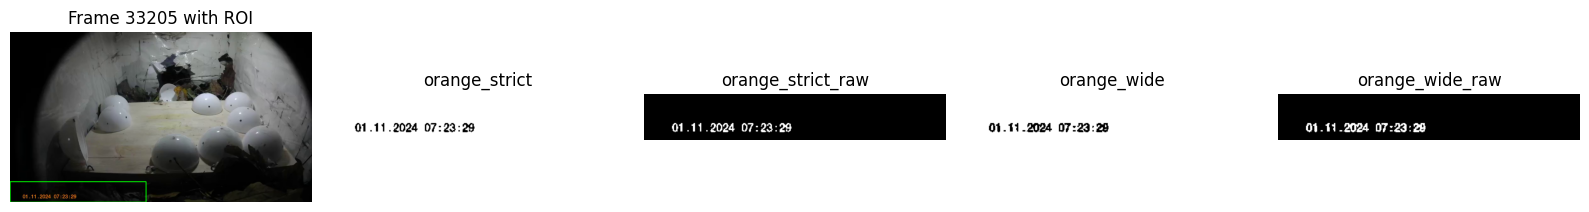

In [7]:
import matplotlib.pyplot as plt

def roi_rel_to_abs(frame_shape: Tuple[int, int, int], roi_rel: Tuple[float, float, float, float]) -> Tuple[int, int, int, int]:
    H, W = frame_shape[:2]
    x0, y0, x1, y1 = roi_rel
    xa = int(round(x0 * W))
    ya = int(round(y0 * H))
    xb = int(round(x1 * W))
    yb = int(round(y1 * H))
    xa = clamp_int(xa, 0, W - 1)
    xb = clamp_int(xb, 0, W)
    ya = clamp_int(ya, 0, H - 1)
    yb = clamp_int(yb, 0, H)
    if xb <= xa:
        xb = min(W, xa + 1)
    if yb <= ya:
        yb = min(H, ya + 1)
    return xa, ya, xb, yb

def preprocess_timestamp_roi_variants(roi_bgr: np.ndarray) -> List[np.ndarray]:
    """Generate multiple preprocessing variants for robust OCR."""
    SCALE = 3
    variants: List[Tuple[str, np.ndarray]] = []

    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    lower_orange = np.array([5, 80, 80], dtype=np.uint8)
    upper_orange = np.array([25, 255, 255], dtype=np.uint8)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    lower_wide = np.array([0, 50, 50], dtype=np.uint8)
    upper_wide = np.array([30, 255, 255], dtype=np.uint8)
    mask_wide = cv2.inRange(hsv, lower_wide, upper_wide)

    for label, mask in [("orange_strict", mask_orange), ("orange_wide", mask_wide)]:
        big = cv2.resize(mask, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_NEAREST)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        big = cv2.morphologyEx(big, cv2.MORPH_CLOSE, kernel)
        inv = 255 - big
        variants.append((label, inv))
        variants.append((label + "_raw", big))

    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    big_gray = cv2.resize(gray, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(big_gray)
    variants.append(("clahe", enhanced))
    variants.append(("clahe_inv", 255 - enhanced))

    adaptive = cv2.adaptiveThreshold(
        big_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 5
    )
    variants.append(("adaptive", adaptive))
    variants.append(("adaptive_inv", 255 - adaptive))

    return variants

def show_roi_preview(video_path: Path, roi_rel: Tuple[float, float, float, float], frame_pos: float = 0.5) -> None:
    info = get_video_info(video_path)
    fi = int(round(frame_pos * max(0, info["frame_count"] - 1)))
    cap = cv2.VideoCapture(str(video_path))
    frame = grab_frame(cap, fi)
    cap.release()
    if frame is None:
        raise RuntimeError("Could not read preview frame.")

    xa, ya, xb, yb = roi_rel_to_abs(frame.shape, roi_rel)
    frame_vis = frame.copy()
    cv2.rectangle(frame_vis, (xa, ya), (xb, yb), (0, 255, 0), 2)

    roi = frame[ya:yb, xa:xb].copy()
    variants = preprocess_timestamp_roi_variants(roi)

    n_show = min(len(variants), 4)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, n_show + 1, 1)
    plt.title(f"Frame {fi} with ROI")
    plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    for i, (label, var) in enumerate(variants[:n_show]):
        plt.subplot(1, n_show + 1, i + 2)
        plt.title(label)
        plt.imshow(var, cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show ROI preview from first video
show_roi_preview(video_sources[0].processed_path, TS_ROI_REL, frame_pos=0.5)

## 7) Build a time calibration model per video (frame → wallclock datetime)

We read the on-video timestamp overlay at multiple frame positions using OCR and fit a linear model
per video:

$$t_{epoch}(frame) = a + b \cdot frame$$

This compensates for **timestamp drift** and for variable frame timing.
Each video gets its own model; the per-video model is stored in the corresponding `VideoSource`.

If OCR fails for a video, the cell automatically falls back to a **manual 2-point calibration**.

In [8]:
# ============================================================
# Cell 7 – Time calibration  (frame index → wallclock datetime)
# ============================================================
from collections import Counter

# --- Timestamp regex ---
TS_REGEX_DMY = re.compile(
    r"(?P<dd>\d{2})[.\-/ ](?P<mm>\d{2})[.\-/ ](?P<yyyy>\d{4})"
    r"\s+"
    r"(?P<hh>\d{2})[: ](?P<mi>\d{2})[: ](?P<ss>\d{2})"
)
TS_REGEX_YMD = re.compile(
    r"(?P<yyyy>\d{4})[.\-/ ](?P<mm>\d{2})[.\-/ ](?P<dd>\d{2})"
    r"\s+"
    r"(?P<hh>\d{2})[: ](?P<mi>\d{2})[: ](?P<ss>\d{2})"
)
TS_REGEX_DATE_ONLY_DMY = re.compile(
    r"(?P<dd>\d{2})[.\-/ ](?P<mm>\d{2})[.\-/ ](?P<yyyy>\d{4})$"
)

def _parse_date_and_time(text: str) -> Optional[Tuple[Tuple[int,int,int], Tuple[int,int,int]]]:
    if not text:
        return None
    t = str(text).strip()
    t = t.replace(",", ".").replace("|", "1").replace("O", "0").replace("o", "0")
    t = re.sub(r"\s+", " ", t)
    for rx in (TS_REGEX_DMY, TS_REGEX_YMD):
        m = rx.search(t)
        if m:
            try:
                dd, mm, yyyy = int(m.group("dd")), int(m.group("mm")), int(m.group("yyyy"))
                hh, mi, ss = int(m.group("hh")), int(m.group("mi")), int(m.group("ss"))
                if not (2000 <= yyyy <= 2099 and 1 <= mm <= 12 and 1 <= dd <= 31):
                    continue
                return (yyyy, mm, dd), (hh, mi, ss)
            except Exception:
                pass
    return None

def _parse_date_only(text: str) -> Optional[Tuple[int,int,int]]:
    if not text:
        return None
    t = str(text).strip()
    t = t.replace(",", ".").replace("|", "1").replace("O", "0").replace("o", "0")
    t = re.sub(r"\s+", " ", t)
    m = TS_REGEX_DATE_ONLY_DMY.search(t)
    if m:
        dd, mm, yyyy = int(m.group("dd")), int(m.group("mm")), int(m.group("yyyy"))
        if 2000 <= yyyy <= 2099 and 1 <= mm <= 12 and 1 <= dd <= 31:
            return (yyyy, mm, dd)
    return None

def parse_timestamp_text(text: str) -> Optional[datetime]:
    r = _parse_date_and_time(text)
    if r is None:
        return None
    (yyyy, mm, dd), (hh, mi, ss) = r
    if hh == 0 and mi == 0 and ss == 0:
        return None
    try:
        return datetime(yyyy, mm, dd, hh, mi, ss)
    except ValueError:
        return None

# --- TimeModel ---
@dataclass
class TimeModel:
    a_epoch: float
    b_per_frame: float

    def epoch_for_frame(self, frame_idx: int) -> float:
        return self.a_epoch + self.b_per_frame * frame_idx

    def dt_for_frame(self, frame_idx: int) -> datetime:
        return datetime.fromtimestamp(self.epoch_for_frame(frame_idx))

def fit_time_model(points: List[Tuple[int, datetime]], expected_spf: float) -> TimeModel:
    if len(points) < 2:
        raise RuntimeError("Need >= 2 points.")
    xs = np.array([p[0] for p in points], dtype=np.float64)
    ys = np.array([p[1].timestamp() for p in points], dtype=np.float64)

    keep = np.ones(len(xs), dtype=bool)
    for tol_s in [5.0, 10.0, 30.0]:
        xk, yk = xs[keep], ys[keep]
        if len(xk) < 2:
            keep[:] = True
            xk, yk = xs, ys
        b, a = np.polyfit(xk, yk, 1)
        resid = np.abs((b * xs + a) - ys)
        new_keep = resid < tol_s
        if new_keep.sum() >= 2:
            keep = new_keep

    xk, yk = xs[keep], ys[keep]
    if len(xk) < 2:
        xk, yk = xs, ys
    b, a = np.polyfit(xk, yk, 1)

    if expected_spf > 0:
        ratio = b / expected_spf
        if ratio < 0.5 or ratio > 2.0:
            raise RuntimeError(
                f"Model b_per_frame={b:.6f} is far from expected 1/fps={expected_spf:.6f} "
                f"(ratio={ratio:.2f}). OCR timestamps are likely wrong."
            )
    return TimeModel(a_epoch=float(a), b_per_frame=float(b))

# --- OCR helpers ---
def _try_parse_texts(texts: List[str]) -> Tuple[Optional[Tuple], Optional[Tuple]]:
    """Try to extract (date_tuple, time_tuple) from a list of OCR text strings."""
    candidates = list(texts)
    if len(texts) > 1:
        candidates.append(" ".join(texts))
    for i in range(len(texts) - 1):
        candidates.append(texts[i] + " " + texts[i + 1])
    best_date, best_time = None, None
    for txt in candidates:
        r = _parse_date_and_time(txt)
        if r is not None:
            d, t = r
            if best_date is None:
                best_date = d
            if best_time is None and not (t[0] == 0 and t[1] == 0 and t[2] == 0):
                best_time = t
            if best_date is not None and best_time is not None:
                return best_date, best_time
    if best_date is None:
        for txt in candidates:
            d = _parse_date_only(txt)
            if d is not None:
                best_date = d
                break
    return best_date, best_time

def ocr_frame_candidates(
    frame_bgr: np.ndarray,
    roi_rel: Tuple[float, float, float, float],
    reader,
    debug_dir: Optional[Path] = None,
    debug_tag: str = "",
) -> Tuple[Optional[Tuple[int,int,int]], Optional[Tuple[int,int,int]], List[str]]:
    xa, ya, xb, yb = roi_rel_to_abs(frame_bgr.shape, roi_rel)
    roi = frame_bgr[ya:yb, xa:xb].copy()

    if debug_dir:
        ensure_dir(debug_dir)
        cv2.imwrite(str(debug_dir / f"roi_{debug_tag}_original.png"), roi)

    variants = preprocess_timestamp_roi_variants(roi)
    all_texts: List[str] = []
    best_date: Optional[Tuple] = None
    best_time: Optional[Tuple] = None

    for var_label, var_img in variants:
        if debug_dir:
            cv2.imwrite(str(debug_dir / f"roi_{debug_tag}_{var_label}.png"), var_img)
        try:
            results = reader.readtext(var_img, detail=1, paragraph=False)
        except Exception:
            results = []
        var_texts = [str(txt) for _bbox, txt, _conf in results]
        all_texts.extend(var_texts)

        # Try to parse from this variant's texts (and combinations with accumulated texts)
        d, t = _try_parse_texts(var_texts)
        if d is not None and best_date is None:
            best_date = d
        if t is not None and best_time is None:
            best_time = t

        # If still incomplete, try across all accumulated texts so far
        if best_date is None or best_time is None:
            d2, t2 = _try_parse_texts(all_texts)
            if d2 is not None and best_date is None:
                best_date = d2
            if t2 is not None and best_time is None:
                best_time = t2

        # Early exit: no need to run more variants once we have a complete timestamp
        if best_date is not None and best_time is not None:
            break

    if debug_dir:
        with open(debug_dir / f"roi_{debug_tag}_result.txt", "w") as f:
            f.write(f"date={best_date} time={best_time}\nraw={all_texts}\n")

    return best_date, best_time, all_texts

def build_time_model_auto(
    video_path: Path,
    roi_rel: Tuple[float, float, float, float],
    n_samples: int = 18,
    debug_dir: Optional[Path] = None,
) -> Tuple[TimeModel, List[Tuple[int, datetime]]]:
    import easyocr
    reader = easyocr.Reader(["en"], gpu=False)

    info = get_video_info(video_path)
    fps = info["fps"]
    frame_count = int(info["frame_count"])
    expected_spf = 1.0 / fps if fps > 0 else 0

    n_samples = max(3, int(n_samples))
    sample_frames = np.linspace(0, frame_count - 1, n_samples).astype(int).tolist()

    cap = cv2.VideoCapture(str(video_path))
    raw_results: List[Tuple[int, Optional[Tuple], Optional[Tuple]]] = []
    date_counter: Counter = Counter()

    for fi in tqdm(sample_frames, desc="OCR samples", unit="frame"):
        frame = grab_frame(cap, int(fi))
        if frame is None:
            continue
        d, t, _ = ocr_frame_candidates(
            frame, roi_rel=roi_rel, reader=reader,
            debug_dir=debug_dir, debug_tag=f"f{fi:07d}",
        )
        raw_results.append((fi, d, t))
        if d is not None:
            date_counter[d] += 1
    cap.release()

    if not date_counter:
        raise RuntimeError("OCR could not extract any dates at all.")

    consensus_date = date_counter.most_common(1)[0][0]
    print(f"[INFO] Consensus date: {consensus_date[2]:02d}.{consensus_date[1]:02d}.{consensus_date[0]}"
          f" (seen {date_counter[consensus_date]}x out of {sum(date_counter.values())} dates)")

    points: List[Tuple[int, datetime]] = []
    yyyy, mm, dd = consensus_date
    for fi, d, t in raw_results:
        if t is None:
            continue
        hh, mi, ss = t
        if hh == 0 and mi == 0 and ss == 0:
            continue
        try:
            dt = datetime(yyyy, mm, dd, hh, mi, ss)
            points.append((fi, dt))
        except ValueError:
            continue

    print(f"[INFO] Valid time points: {len(points)} / {len(raw_results)}")
    for fi, dt in points:
        print(f"   frame {fi:>7d} → {dt}")

    if len(points) < 2:
        raise RuntimeError(
            f"Only {len(points)} valid timestamp(s) after consensus filtering.\n"
            f"Check ocr_debug/ for details."
        )

    tm = fit_time_model(points, expected_spf=expected_spf)
    return tm, points

def build_time_model_manual(
    video_path: Path,
    roi_rel: Tuple[float, float, float, float],
    video_label: str = "",
) -> TimeModel:
    info = get_video_info(video_path)
    frame_count = int(info["frame_count"])
    cap = cv2.VideoCapture(str(video_path))
    frame0 = grab_frame(cap, 0)
    frame_last = grab_frame(cap, frame_count - 1)
    cap.release()

    if frame0 is None or frame_last is None:
        raise RuntimeError("Could not read first/last frame.")

    def _show(frame_bgr, title):
        xa, ya, xb, yb = roi_rel_to_abs(frame_bgr.shape, roi_rel)
        roi = frame_bgr[ya:yb, xa:xb]
        plt.figure(figsize=(10, 3))
        plt.title(title, fontsize=14, fontweight="bold")
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    prefix = f"[{video_label}] " if video_label else ""
    _show(frame0, f"{prefix}FIRST frame timestamp")
    _show(frame_last, f"{prefix}LAST frame timestamp")

    s0 = input(f"{prefix}Timestamp ERSTES Bild (z.B. 02.10.2024 10:48:54): ").strip()
    s1 = input(f"{prefix}Timestamp LETZTES Bild (z.B. 02.10.2024 12:15:03): ").strip()

    dt0 = parse_timestamp_text(s0)
    dt1 = parse_timestamp_text(s1)

    if dt0 is None or dt1 is None:
        raise RuntimeError(
            f"Konnte Timestamps nicht parsen: '{s0}' → {dt0}, '{s1}' → {dt1}\n"
            f"Format: DD.MM.YYYY HH:MM:SS"
        )

    if dt1 <= dt0:
        dt1 += timedelta(days=1)

    b = (dt1.timestamp() - dt0.timestamp()) / float(frame_count - 1)
    a = dt0.timestamp()
    return TimeModel(a_epoch=float(a), b_per_frame=float(b))

# ============================================================
# Run calibration for each video
# ============================================================
OCR_DEBUG_DIR = OUTPUT_DIR / "ocr_debug"

for vs in video_sources:
    print(f"\n{'='*60}")
    print(f"Video {vs.idx+1}/{len(video_sources)}: {vs.original_path.name}")
    print(f"{'='*60}")

    vid_debug_dir = OCR_DEBUG_DIR / f"video_{vs.idx}"
    if vid_debug_dir.exists():
        import shutil
        try:
            shutil.rmtree(vid_debug_dir)
        except PermissionError:
            # Windows may lock the directory; skip deletion and reuse it
            pass
    vid_debug_dir.mkdir(parents=True, exist_ok=True)

    try:
        tm, pts = build_time_model_auto(
            vs.processed_path,
            roi_rel=TS_ROI_REL,
            n_samples=OCR_N_SAMPLES,
            debug_dir=vid_debug_dir,
        )
        vs.time_model = tm
        print(f"✅ OCR time model fitted using {len(pts)} points.")

    except Exception as e:
        print(f"⚠️  OCR failed: {e}")
        print("→ Manual fallback ...\n")
        vs.time_model = build_time_model_manual(
            vs.processed_path, TS_ROI_REL, video_label=vs.original_path.name
        )

    print(f"  Time model: {vs.time_model}")
    print(f"  frame 0     → {vs.time_model.dt_for_frame(0)}")
    print(f"  last frame  → {vs.time_model.dt_for_frame(int(vs.info['frame_count']) - 1)}")

print("\n[INFO] All time models fitted.")


Video 1/6: 20241101_TrepN_04_in (1).mp4


Using CPU. Note: This module is much faster with a GPU.
OCR samples:   0%|          | 0/18 [00:00<?, ?frame/s]c:\Users\d.weiss\OneDrive - con terra\Dokumente\GitHub\Squirrels\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
OCR samples: 100%|██████████| 18/18 [02:21<00:00,  7.88s/frame]
Using CPU. Note: This module is much faster with a GPU.


[INFO] Consensus date: 01.11.2024 (seen 17x out of 17 dates)
[INFO] Valid time points: 11 / 18
   frame       0 → 2024-11-01 07:05:19
   frame   11719 → 2024-11-01 07:11:43
   frame   15625 → 2024-11-01 07:13:52
   frame   19532 → 2024-11-01 07:16:00
   frame   27345 → 2024-11-01 07:20:16
   frame   31251 → 2024-11-01 07:22:25
   frame   42971 → 2024-11-01 07:28:50
   frame   50784 → 2024-11-01 07:33:06
   frame   58597 → 2024-11-01 07:37:23
   frame   62503 → 2024-11-01 07:39:31
   frame   66410 → 2024-11-01 07:41:39
✅ OCR time model fitted using 11 points.
  Time model: TimeModel(a_epoch=1730441118.6932106, b_per_frame=0.032834651667754906)
  frame 0     → 2024-11-01 07:05:18.693211
  last frame  → 2024-11-01 07:41:39.242428

Video 2/6: 20241101_TrepN_04_in (2).mp4


OCR samples: 100%|██████████| 18/18 [02:13<00:00,  7.44s/frame]
Using CPU. Note: This module is much faster with a GPU.


[INFO] Consensus date: 01.11.2024 (seen 15x out of 15 dates)
[INFO] Valid time points: 11 / 18
   frame       0 → 2024-11-01 07:41:41
   frame    3906 → 2024-11-01 07:43:49
   frame    7812 → 2024-11-01 07:45:57
   frame   11719 → 2024-11-01 07:48:05
   frame   35157 → 2024-11-01 08:00:55
   frame   39063 → 2024-11-01 08:03:03
   frame   42969 → 2024-11-01 08:05:12
   frame   50782 → 2024-11-01 08:09:28
   frame   54688 → 2024-11-01 08:11:30
   frame   62501 → 2024-11-01 08:15:53
   frame   66408 → 2024-11-01 08:16:01
✅ OCR time model fitted using 11 points.
  Time model: TimeModel(a_epoch=1730443300.9681146, b_per_frame=0.03280433333135329)
  frame 0     → 2024-11-01 07:41:40.968115
  last frame  → 2024-11-01 08:17:59.438282

Video 3/6: 20241101_TrepN_04_in (3).mp4


OCR samples: 100%|██████████| 18/18 [01:56<00:00,  6.45s/frame]
Using CPU. Note: This module is much faster with a GPU.


[INFO] Consensus date: 01.11.2024 (seen 18x out of 18 dates)
[INFO] Valid time points: 17 / 18
   frame       0 → 2024-11-01 08:18:03
   frame    3906 → 2024-11-01 08:20:11
   frame    7812 → 2024-11-01 08:22:19
   frame   11718 → 2024-11-01 09:24:27
   frame   15624 → 2024-11-01 08:26:36
   frame   19530 → 2024-11-01 08:28:44
   frame   23436 → 2024-11-01 08:30:52
   frame   27342 → 2024-11-01 08:33:00
   frame   31248 → 2024-11-01 08:35:09
   frame   35154 → 2024-11-01 08:37:17
   frame   39060 → 2024-11-01 08:39:25
   frame   42966 → 2024-11-01 08:41:33
   frame   46872 → 2024-11-01 08:43:42
   frame   50778 → 2024-11-01 08:45:50
   frame   58590 → 2024-11-01 08:50:06
   frame   62496 → 2024-11-01 09:52:14
   frame   66403 → 2024-11-01 08:54:23
✅ OCR time model fitted using 17 points.
  Time model: TimeModel(a_epoch=1730445734.0812867, b_per_frame=0.03822118323688336)
  frame 0     → 2024-11-01 08:22:14.081287
  last frame  → 2024-11-01 09:04:32.082517

Video 4/6: 20241101_TrepN_04_

OCR samples: 100%|██████████| 18/18 [01:15<00:00,  4.17s/frame]
Using CPU. Note: This module is much faster with a GPU.


[INFO] Consensus date: 01.11.2024 (seen 17x out of 17 dates)
[INFO] Valid time points: 17 / 18
   frame       0 → 2024-11-01 08:54:24
   frame    3906 → 2024-11-01 08:56:32
   frame    7812 → 2024-11-01 08:58:41
   frame   15625 → 2024-11-01 09:02:57
   frame   19532 → 2024-11-01 09:05:05
   frame   23438 → 2024-11-01 09:07:14
   frame   27345 → 2024-11-01 09:09:22
   frame   31251 → 2024-11-01 04:11:30
   frame   35158 → 2024-11-01 09:13:39
   frame   39064 → 2024-11-01 09:15:47
   frame   42971 → 2024-11-01 09:17:55
   frame   46877 → 2024-11-01 09:20:04
   frame   50784 → 2024-11-01 09:22:12
   frame   54690 → 2024-11-01 09:24:20
   frame   58597 → 2024-11-01 09:26:28
   frame   62503 → 2024-11-01 09:28:37
   frame   66410 → 2024-11-01 09:30:45
✅ OCR time model fitted using 17 points.
  Time model: TimeModel(a_epoch=1730446316.0445285, b_per_frame=0.041229980411561194)
  frame 0     → 2024-11-01 08:31:56.044528
  last frame  → 2024-11-01 09:17:34.127528

Video 5/6: 20241101_TrepN_04

OCR samples: 100%|██████████| 18/18 [01:16<00:00,  4.24s/frame]
Using CPU. Note: This module is much faster with a GPU.


[INFO] Consensus date: 01.11.2024 (seen 18x out of 18 dates)
[INFO] Valid time points: 18 / 18
   frame       0 → 2024-11-01 09:30:46
   frame    3906 → 2024-11-01 09:32:54
   frame    7812 → 2024-11-01 09:35:03
   frame   11719 → 2024-11-01 09:37:11
   frame   15625 → 2024-11-01 09:39:19
   frame   19531 → 2024-11-01 09:41:27
   frame   23438 → 2024-11-01 09:43:36
   frame   27344 → 2024-11-01 09:45:44
   frame   31250 → 2024-11-01 09:47:52
   frame   35157 → 2024-11-01 09:50:01
   frame   39063 → 2024-11-01 09:52:09
   frame   42969 → 2024-11-01 09:54:17
   frame   46876 → 2024-11-01 09:56:25
   frame   50782 → 2024-11-01 09:58:34
   frame   54688 → 2024-11-01 10:00:42
   frame   58595 → 2024-11-01 10:02:50
   frame   62501 → 2024-11-01 10:04:58
   frame   66408 → 2024-11-01 10:07:07
✅ OCR time model fitted using 18 points.
  Time model: TimeModel(a_epoch=1730449846.058497, b_per_frame=0.032837760116282)
  frame 0     → 2024-11-01 09:30:46.058497
  last frame  → 2024-11-01 10:07:06.7

OCR samples: 100%|██████████| 18/18 [01:45<00:00,  5.86s/frame]

[INFO] Consensus date: 01.11.2024 (seen 18x out of 18 dates)
[INFO] Valid time points: 17 / 18
   frame       0 → 2024-11-01 10:07:08
   frame    3906 → 2024-11-01 10:09:16
   frame    7812 → 2024-11-01 10:11:24
   frame   11719 → 2024-11-01 10:13:33
   frame   15625 → 2024-11-01 10:15:41
   frame   19532 → 2024-11-01 10:17:49
   frame   23438 → 2024-11-01 10:19:58
   frame   27345 → 2024-11-01 10:22:06
   frame   31251 → 2024-11-01 10:24:14
   frame   35158 → 2024-11-01 10:26:22
   frame   39064 → 2024-11-01 10:28:31
   frame   46877 → 2024-11-01 10:32:47
   frame   50784 → 2024-11-01 10:34:56
   frame   54690 → 2024-11-01 10:37:04
   frame   58597 → 2024-11-01 10:39:12
   frame   62503 → 2024-11-01 10:41:20
   frame   66410 → 2024-11-01 10:43:29
✅ OCR time model fitted using 17 points.
  Time model: TimeModel(a_epoch=1730452027.8496764, b_per_frame=0.03283972284470105)
  frame 0     → 2024-11-01 10:07:07.849676
  last frame  → 2024-11-01 10:43:28.735671

[INFO] All time models fitted

## 8) Load the YOLO model (`best.pt`)

Make sure `YOLO_WEIGHTS_PATH` points to your weights file.
The model must contain a class named **`squirrel`** (case-insensitive).


In [9]:
if not YOLO_WEIGHTS_PATH.exists():
    raise FileNotFoundError(f"YOLO weights not found: {YOLO_WEIGHTS_PATH}")

try:
    from ultralytics import YOLO
except Exception as e:
    raise RuntimeError(
        "ultralytics is not installed. Run the install cell at the top of this notebook."
    ) from e

yolo_model = YOLO(str(YOLO_WEIGHTS_PATH))
yolo_names = {int(k): str(v) for k, v in yolo_model.names.items()}
yolo_names


{0: 'squirrel', 1: 'nut', 2: 'cup_full', 3: 'cup_empty', 4: 'disco_ball'}

## 9) Filter motion segments with YOLO (`squirrel`)

This step reduces false positives (e.g. a human hand in the frame) by keeping only segments
where the model detects a **squirrel with high confidence**.

If `MANUAL_CONFIRM_SEGMENTS = True`, a thumbnail of the best frame is displayed for each
candidate segment and you can accept or reject it interactively.

YOLO filter [video 6]: 100%|██████████| 11/11 [00:46<00:00,  4.22s/seg]


[INFO] YOLO kept segments: 29 / 61

[INFO] Manual confirmation enabled. Review each segment below.



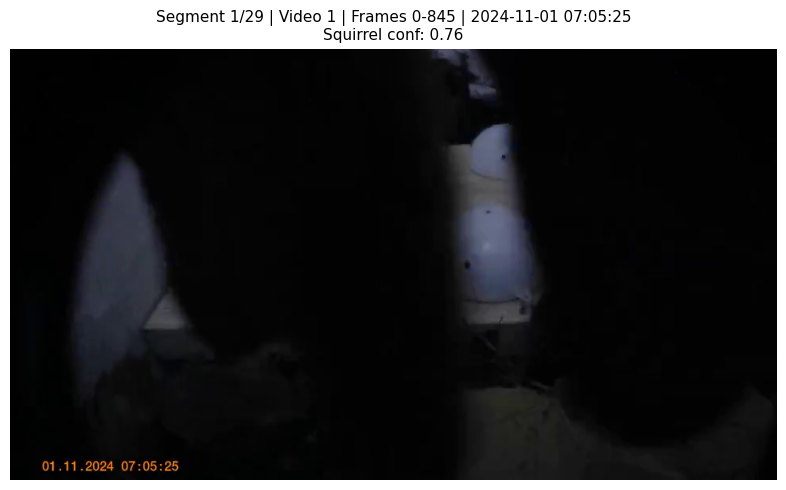

  → Rejected ✗


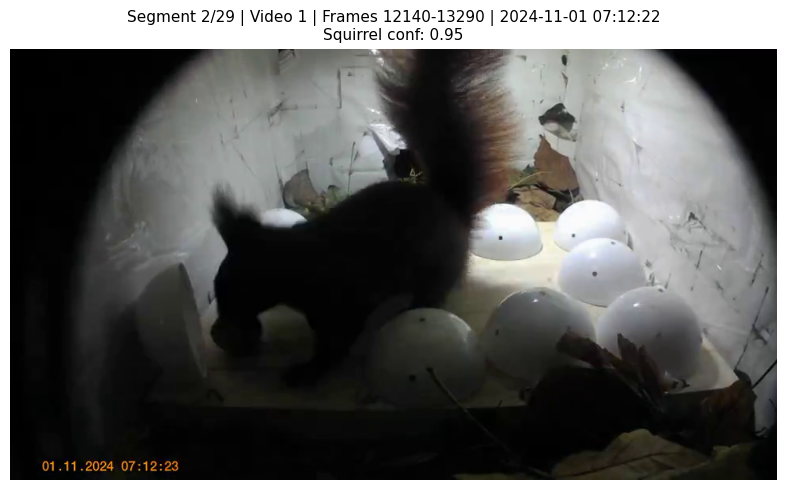

  → Kept ✓


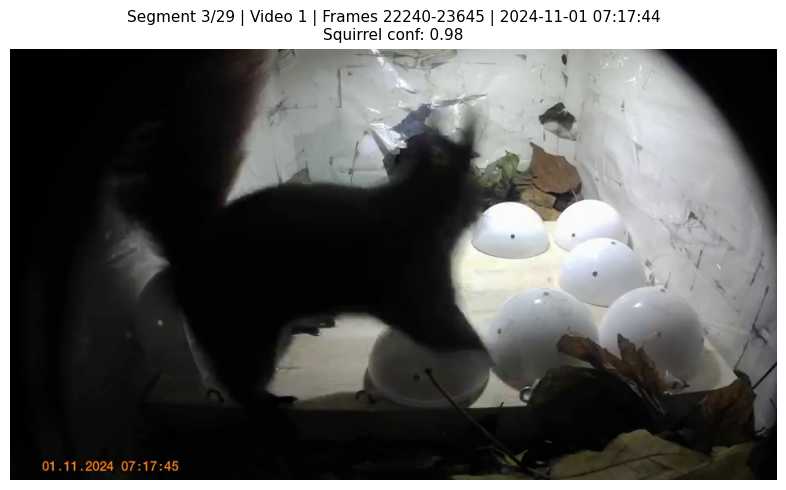

  → Kept ✓


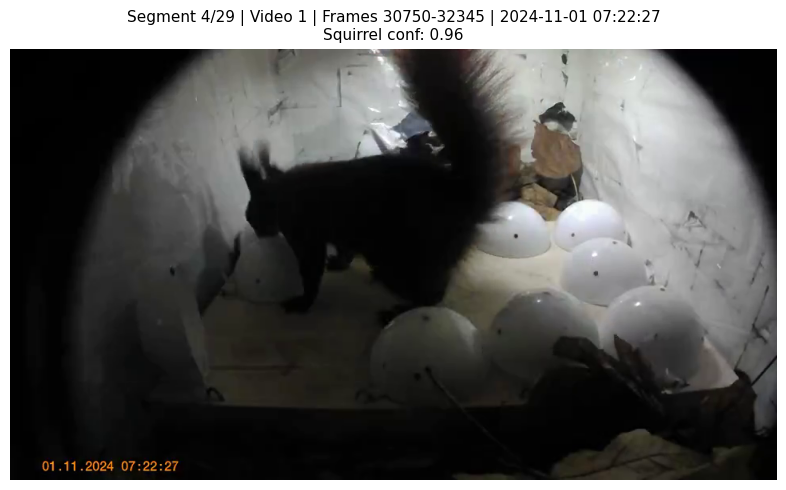

  → Kept ✓


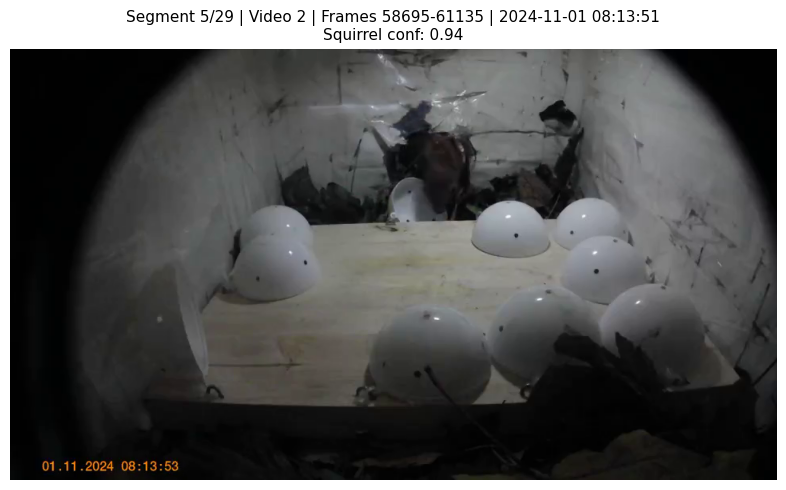

  → Kept ✓


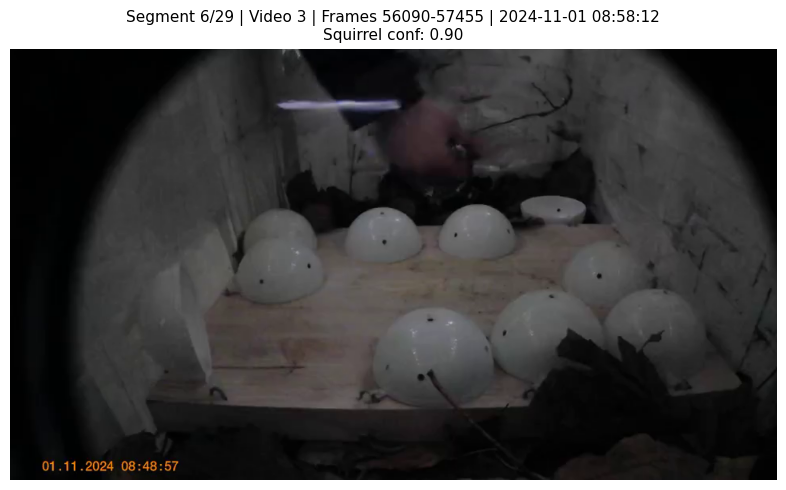

  → Rejected ✗


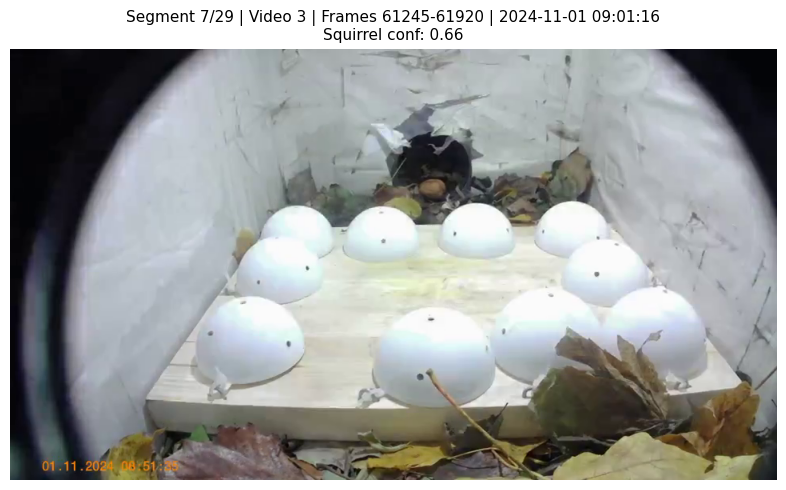

  → Rejected ✗


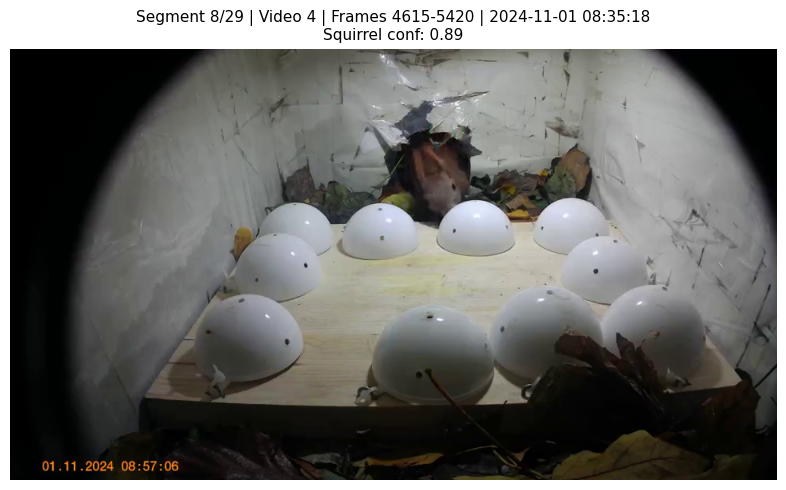

  → Kept ✓


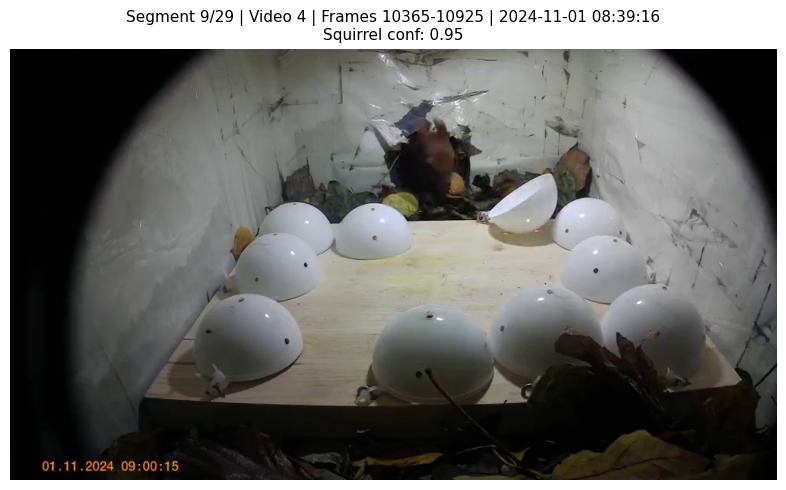

  → Kept ✓


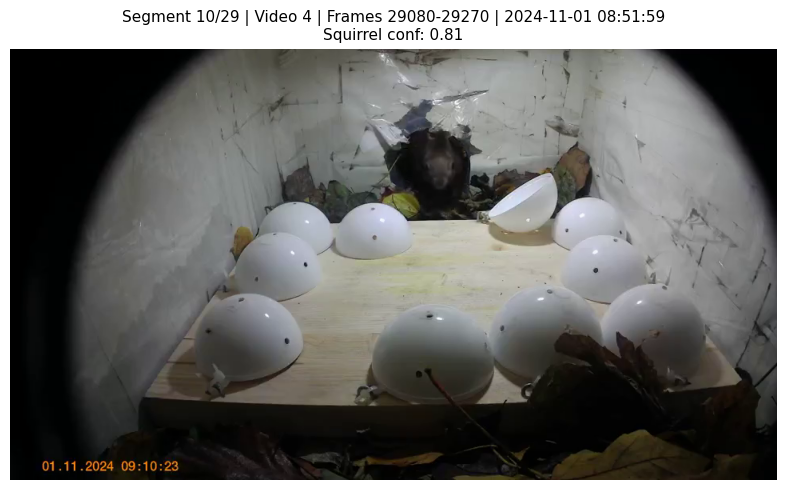

  → Kept ✓


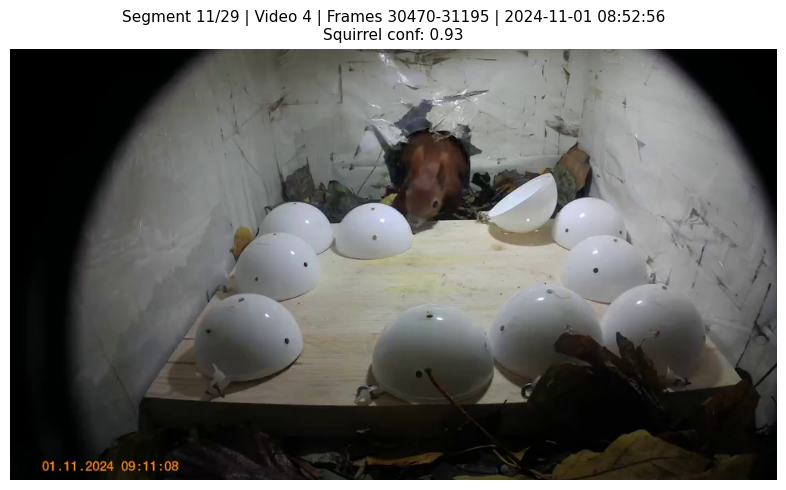

  → Kept ✓


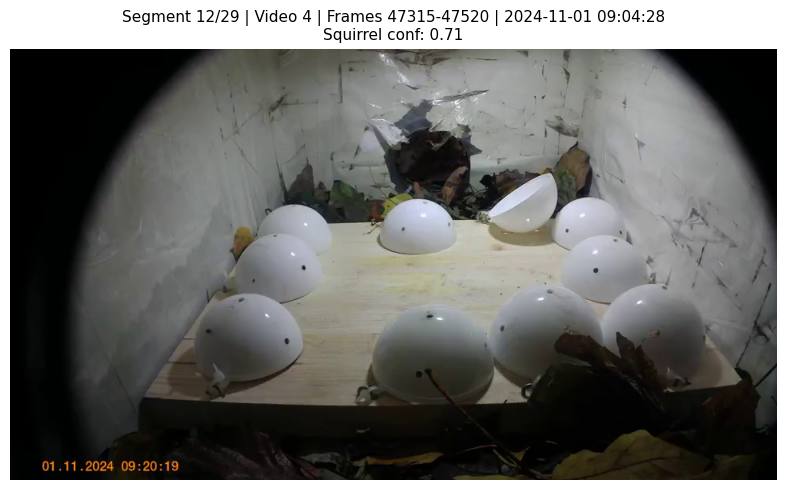

  → Kept ✓


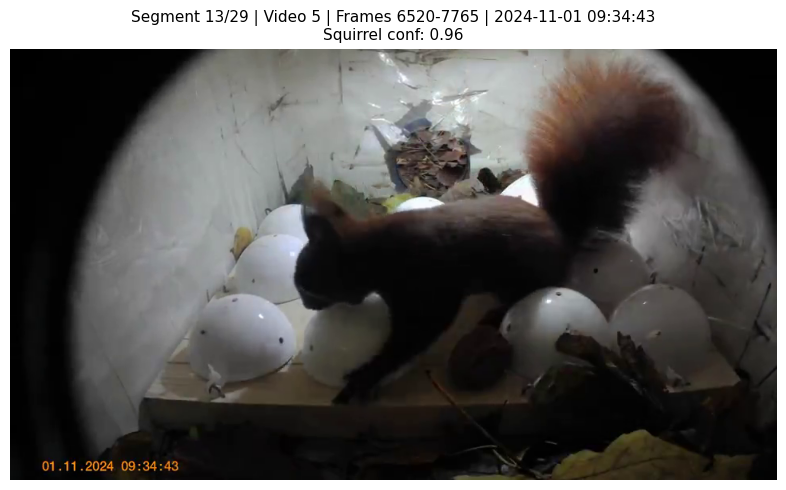

  → Kept ✓


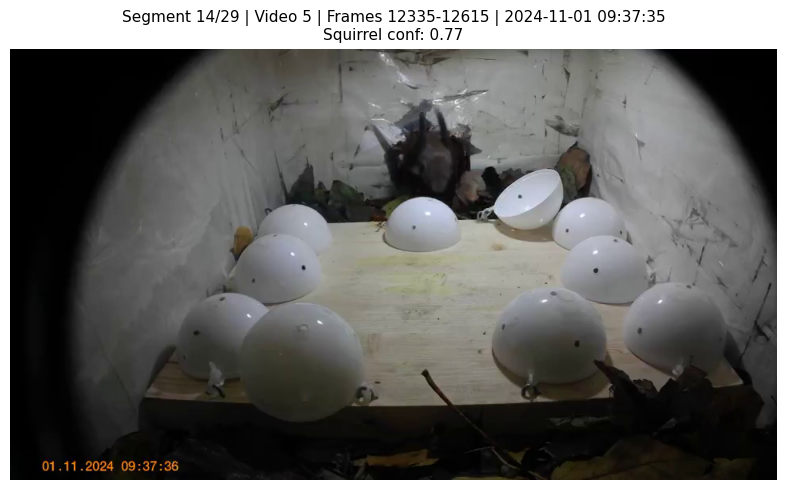

  → Kept ✓


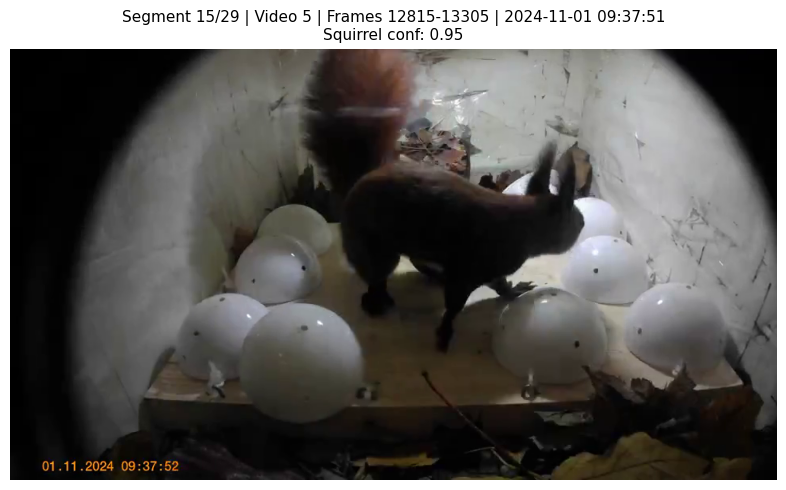

  → Kept ✓


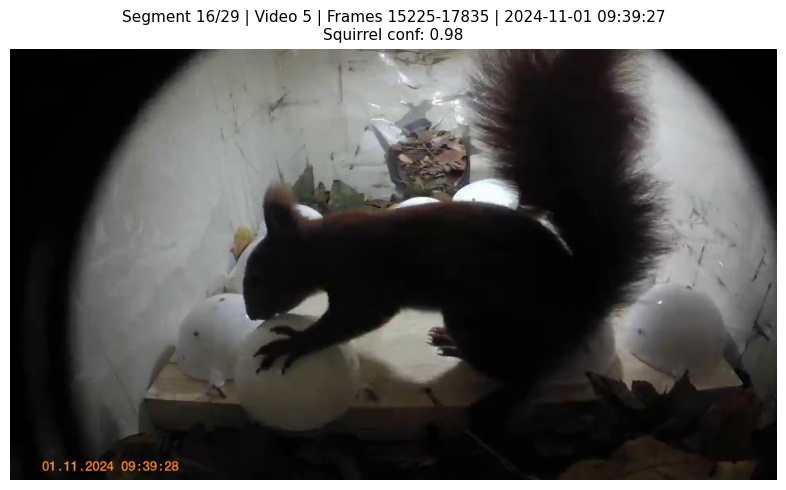

  → Kept ✓


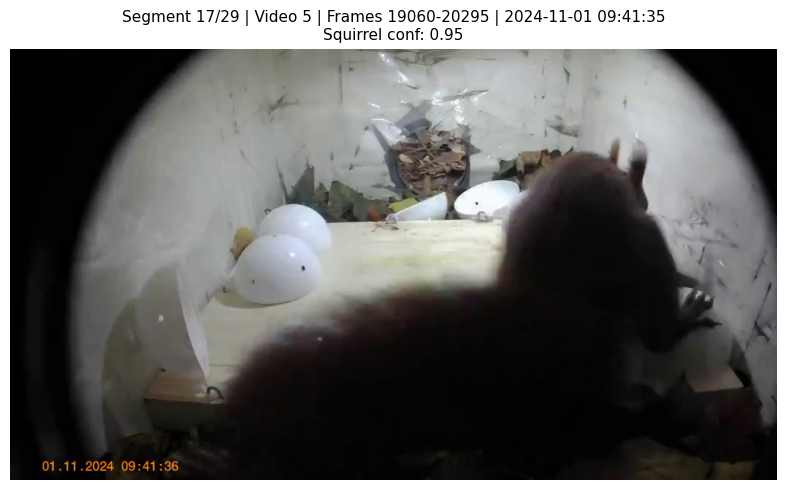

  → Kept ✓


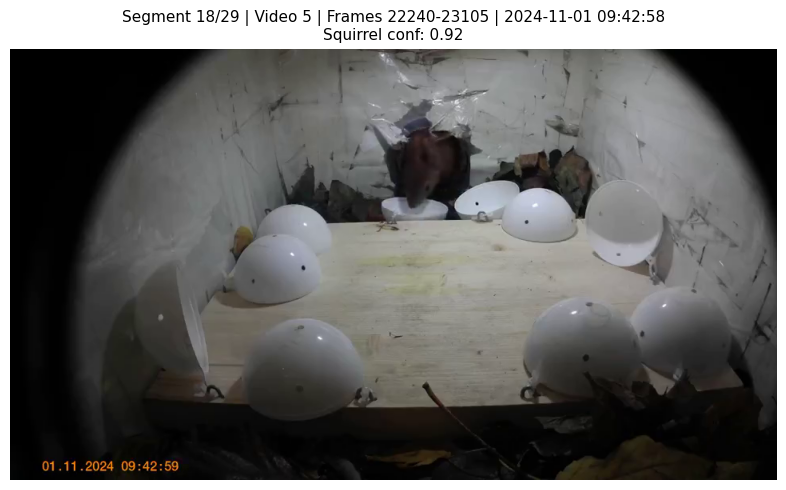

  → Kept ✓


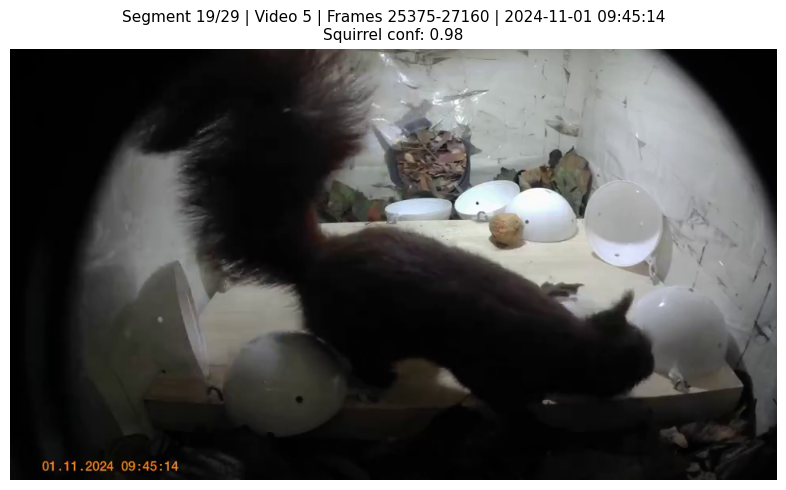

  → Kept ✓


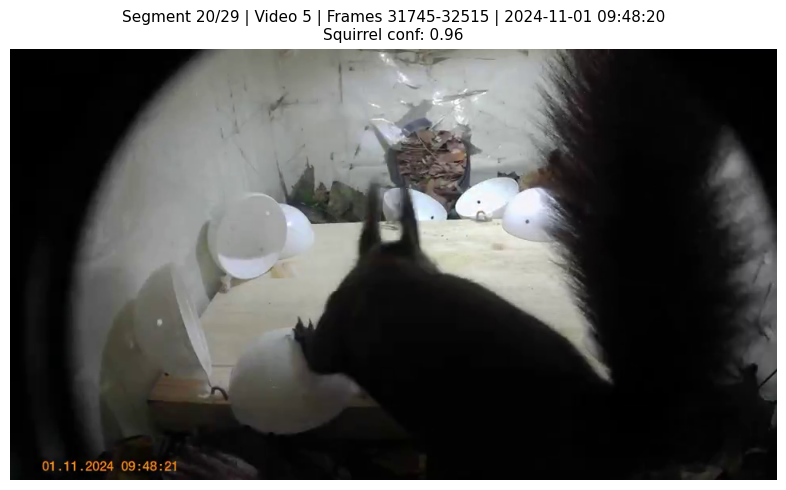

  → Kept ✓


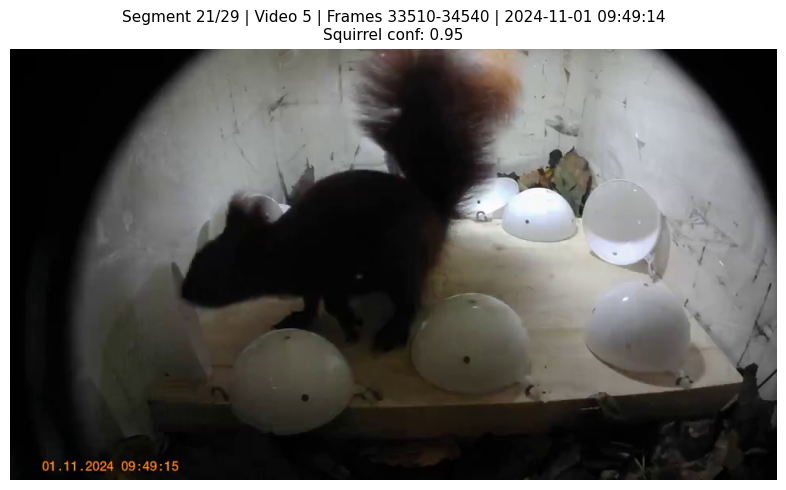

  → Kept ✓


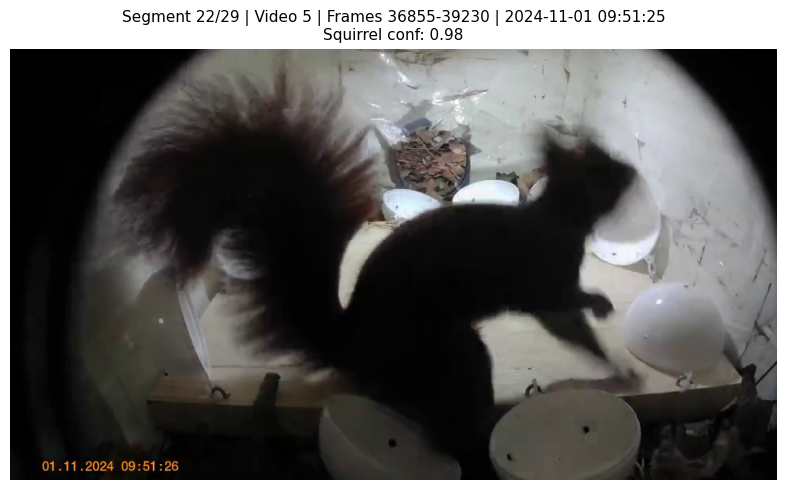

  → Kept ✓


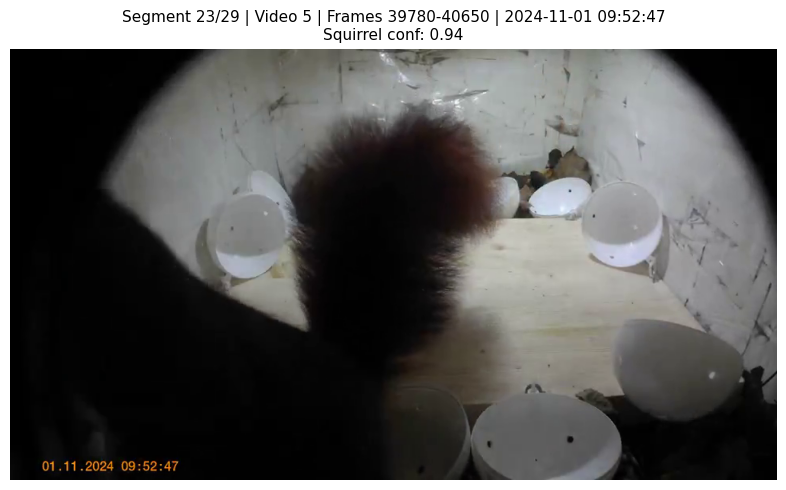

  → Kept ✓


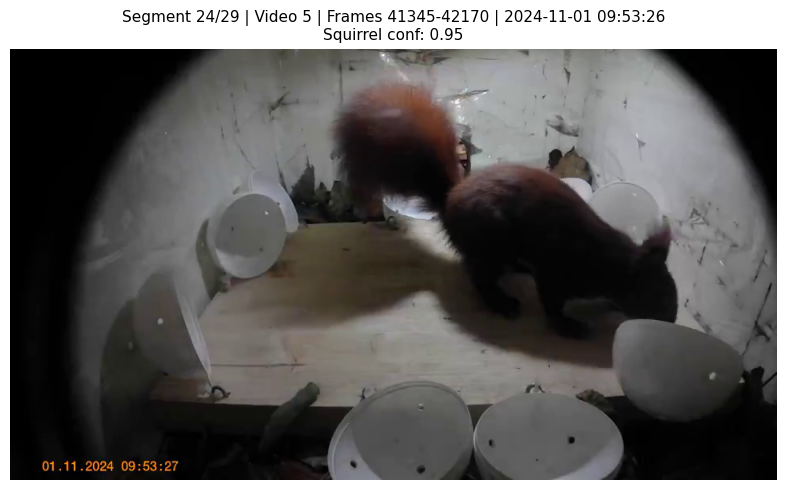

  → Kept ✓


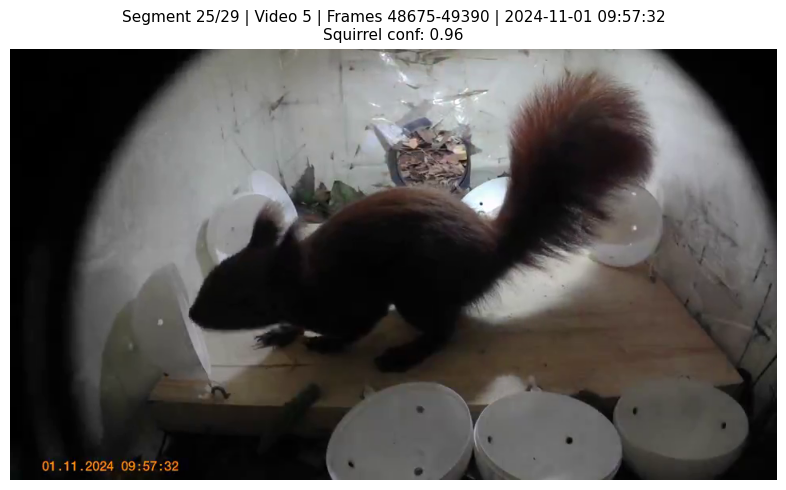

  → Kept ✓


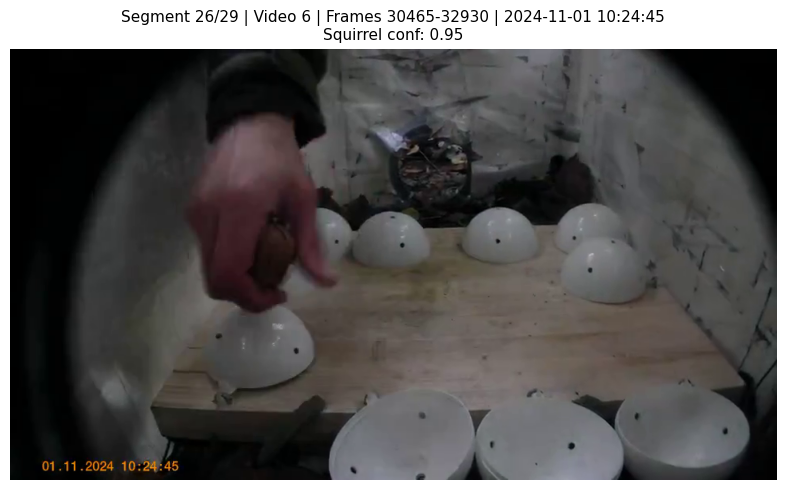

  → Rejected ✗


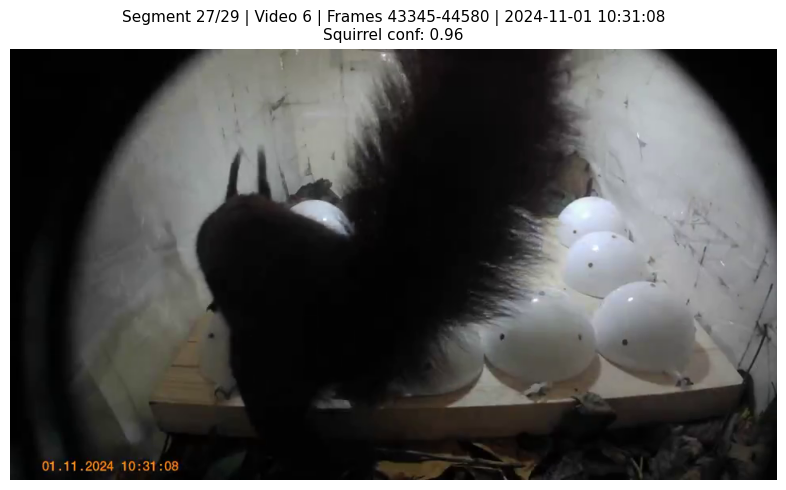

  → Kept ✓


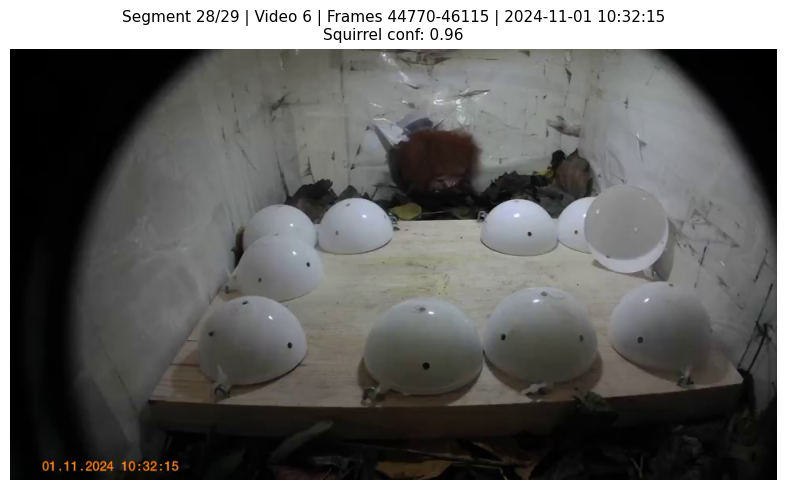

  → Kept ✓


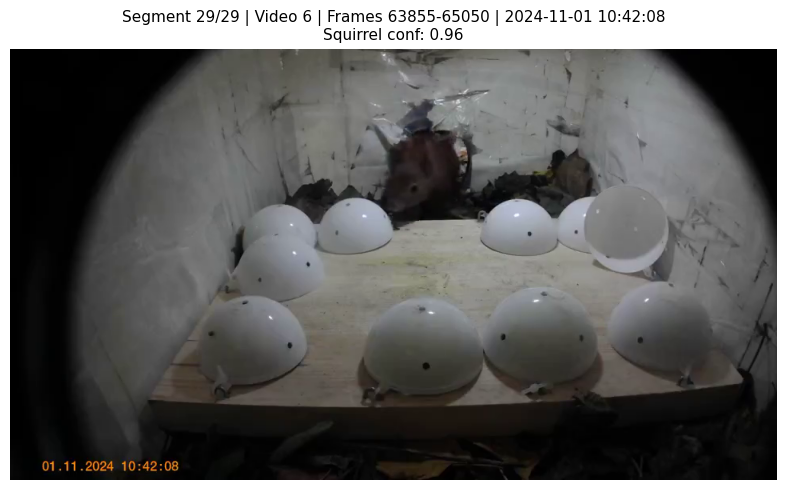

  → Kept ✓

[INFO] After manual review: 25 segments kept.


[KeptSegment(seg_idx=4, video_idx=0, start_frame=12140, end_frame=13290, start_s=405.0713333333333, end_s=443.443, motion_score_max=0.7442862654320987, squirrel_conf_max=0.951948881149292, best_frame=12920),
 KeptSegment(seg_idx=5, video_idx=0, start_frame=22240, end_frame=23645, start_s=742.0746666666666, end_s=788.9548333333333, motion_score_max=0.8693132716049383, squirrel_conf_max=0.9771614074707031, best_frame=22720),
 KeptSegment(seg_idx=6, video_idx=0, start_frame=30750, end_frame=32345, start_s=1026.025, end_s=1079.2448333333334, motion_score_max=0.6716975308641975, squirrel_conf_max=0.9566190838813782, best_frame=31320),
 KeptSegment(seg_idx=10, video_idx=1, start_frame=58695, end_frame=61135, start_s=1958.4565, end_s=2039.8711666666668, motion_score_max=0.30927854938271604, squirrel_conf_max=0.9402630925178528, best_frame=58845),
 KeptSegment(seg_idx=26, video_idx=3, start_frame=4615, end_frame=5420, start_s=153.98716666666667, end_s=180.84733333333332, motion_score_max=0.088

In [10]:
def find_class_id(names_map: Dict[int, str], class_name: str) -> Optional[int]:
    cn = class_name.strip().lower()
    for k, v in names_map.items():
        if str(v).strip().lower() == cn:
            return int(k)
    return None

SQUIRREL_CLS = find_class_id(yolo_names, "squirrel")
if SQUIRREL_CLS is None:
    raise RuntimeError("Your YOLO model does not contain a class named 'squirrel'.")

@dataclass
class KeptSegment:
    seg_idx: int
    video_idx: int       # which video this segment belongs to
    start_frame: int     # frame index within the source video
    end_frame: int
    start_s: float
    end_s: float
    motion_score_max: float
    squirrel_conf_max: float
    best_frame: int      # frame index (within source video) with highest squirrel confidence

def filter_motion_segments_with_yolo(
    video_sources: List[VideoSource],
    motion_segments: List[MotionSegment],
    model,
    squirrel_cls: int,
    conf_thr: float = 0.55,
    imgsz: int = 640,
    device: str = "0",
    sample_fps: float = 2.0,
    batch_size: int = 16,
) -> List[KeptSegment]:
    # Group segments by video_idx
    segs_by_video: Dict[int, List[Tuple[int, MotionSegment]]] = {}
    for i, seg in enumerate(motion_segments):
        segs_by_video.setdefault(seg.video_idx, []).append((i, seg))

    kept: List[KeptSegment] = []

    for vs in video_sources:
        vid_segs = segs_by_video.get(vs.idx, [])
        if not vid_segs:
            continue

        info = vs.info
        fps = info["fps"]
        frame_count = info["frame_count"]
        step = max(1, int(round(fps / max(0.1, float(sample_fps)))))

        cap = cv2.VideoCapture(str(vs.processed_path))
        if not cap.isOpened():
            raise RuntimeError(f"Could not open video: {vs.processed_path}")

        for seg_global_idx, seg in tqdm(vid_segs, desc=f"YOLO filter [video {vs.idx+1}]", unit="seg"):
            f0 = clamp_int(int(seg.start_frame), 0, frame_count - 1)
            f1 = clamp_int(int(seg.end_frame), 0, frame_count - 1)
            if f1 <= f0:
                continue

            sample_frames = list(range(f0, f1 + 1, step))
            if not sample_frames:
                continue

            best_conf = 0.0
            best_frame = sample_frames[0]

            batch_frames_list: List[np.ndarray] = []
            batch_ids: List[int] = []

            def flush_batch():
                nonlocal best_conf, best_frame
                if not batch_frames_list:
                    return
                results = model.predict(batch_frames_list, imgsz=imgsz, conf=0.01, device=device, verbose=False)
                for fi, res in zip(batch_ids, results):
                    if res.boxes is None or len(res.boxes) == 0:
                        continue
                    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
                    cf = res.boxes.conf.detach().cpu().numpy().astype(float)
                    if np.any(cls == squirrel_cls):
                        cmax = float(np.max(cf[cls == squirrel_cls]))
                        if cmax > best_conf:
                            best_conf = cmax
                            best_frame = int(fi)
                batch_frames_list.clear()
                batch_ids.clear()

            for fi in sample_frames:
                frame = grab_frame(cap, int(fi))
                if frame is None:
                    continue
                batch_frames_list.append(frame)
                batch_ids.append(int(fi))
                if len(batch_frames_list) >= batch_size:
                    flush_batch()
            flush_batch()

            if best_conf >= float(conf_thr):
                kept.append(KeptSegment(
                    seg_idx=seg_global_idx,
                    video_idx=vs.idx,
                    start_frame=f0,
                    end_frame=f1,
                    start_s=float(f0) / fps,
                    end_s=float(f1) / fps,
                    motion_score_max=float(seg.motion_score_max),
                    squirrel_conf_max=float(best_conf),
                    best_frame=int(best_frame),
                ))

        cap.release()

    return kept

def manual_confirm_segments(
    video_sources: List[VideoSource],
    segments: List[KeptSegment],
) -> List[KeptSegment]:
    """Show the best frame of each segment and ask the user to confirm."""
    confirmed: List[KeptSegment] = []
    caps: Dict[int, cv2.VideoCapture] = {}

    try:
        for i, seg in enumerate(segments):
            if seg.video_idx not in caps:
                caps[seg.video_idx] = cv2.VideoCapture(str(video_sources[seg.video_idx].processed_path))

            cap = caps[seg.video_idx]
            frame = grab_frame(cap, seg.best_frame)
            if frame is None:
                print(f"  [WARN] Could not read frame {seg.best_frame} for segment {i+1}")
                continue

            vs = video_sources[seg.video_idx]
            dt_str = ""
            if vs.time_model:
                dt_str = vs.time_model.dt_for_frame(seg.best_frame).strftime("%Y-%m-%d %H:%M:%S")

            plt.figure(figsize=(10, 5))
            plt.title(
                f"Segment {i+1}/{len(segments)} | Video {seg.video_idx+1} "
                f"| Frames {seg.start_frame}-{seg.end_frame} | {dt_str}\n"
                f"Squirrel conf: {seg.squirrel_conf_max:.2f}",
                fontsize=11,
            )
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.tight_layout()
            plt.show()

            answer = input(f"  Keep segment {i+1}? (y/n, default=y): ").strip().lower()
            if answer in ("", "y", "yes", "j", "ja"):
                confirmed.append(seg)
                print(f"  → Kept ✓")
            else:
                print(f"  → Rejected ✗")
    finally:
        for c in caps.values():
            c.release()

    return confirmed

# --- Run YOLO filtering ---
kept_segments = filter_motion_segments_with_yolo(
    video_sources,
    motion_segments,
    model=yolo_model,
    squirrel_cls=SQUIRREL_CLS,
    conf_thr=YOLO_CONF_SQUIRREL,
    imgsz=YOLO_IMGSZ,
    device=YOLO_DEVICE,
    sample_fps=YOLO_SAMPLE_FPS,
    batch_size=16,
)

print(f"[INFO] YOLO kept segments: {len(kept_segments)} / {len(motion_segments)}")

# --- Optional manual confirmation ---
if MANUAL_CONFIRM_SEGMENTS:
    print("\n[INFO] Manual confirmation enabled. Review each segment below.\n")
    kept_segments = manual_confirm_segments(video_sources, kept_segments)
    print(f"\n[INFO] After manual review: {len(kept_segments)} segments kept.")

kept_segments[:5]

## 10) Convert kept segments to wallclock timestamps + export

We apply the per-video time model to each segment and write:

- `segments_kept.json`
- `segments_kept.csv`

These contain both **frame indices** (per video) and **real timestamps**, along with the source video name.

In [11]:
def kept_segments_to_df(segments: List[KeptSegment], video_sources: List[VideoSource]) -> pd.DataFrame:
    rows = []
    for s in segments:
        vs = video_sources[s.video_idx]
        tm = vs.time_model
        start_dt = tm.dt_for_frame(int(s.start_frame))
        end_dt = tm.dt_for_frame(int(s.end_frame))
        rows.append({
            "segment_idx": int(s.seg_idx),
            "video_idx": int(s.video_idx),
            "video_name": vs.original_path.name,
            "start_frame": int(s.start_frame),
            "end_frame": int(s.end_frame),
            "start_dt": start_dt,
            "end_dt": end_dt,
            "duration_s": float((end_dt - start_dt).total_seconds()),
            "motion_score_max": float(s.motion_score_max),
            "squirrel_conf_max": float(s.squirrel_conf_max),
            "best_frame": int(s.best_frame),
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values("start_dt").reset_index(drop=True)
    return df

segments_df = kept_segments_to_df(kept_segments, video_sources)
segments_df.to_csv(SEGMENTS_CSV_PATH, index=False)

# JSON export
segments_json = {
    "videos": [str(vs.original_path) for vs in video_sources],
    "time_models": {
        vs.idx: {"a_epoch": vs.time_model.a_epoch, "b_per_frame": vs.time_model.b_per_frame}
        for vs in video_sources if vs.time_model
    },
    "segments": [
        {
            "segment_idx": int(r.segment_idx),
            "video_idx": int(r.video_idx),
            "video_name": str(r.video_name),
            "start_frame": int(r.start_frame),
            "end_frame": int(r.end_frame),
            "start_dt": str(pd.to_datetime(r.start_dt)),
            "end_dt": str(pd.to_datetime(r.end_dt)),
            "duration_s": float(r.duration_s),
            "squirrel_conf_max": float(r.squirrel_conf_max),
            "motion_score_max": float(r.motion_score_max),
        }
        for r in segments_df.itertuples(index=False)
    ],
}
SEGMENTS_JSON_PATH.write_text(json.dumps(segments_json, indent=2, ensure_ascii=False), encoding="utf-8")

print(f"[OK] Wrote: {SEGMENTS_CSV_PATH}")
print(f"[OK] Wrote: {SEGMENTS_JSON_PATH}")
segments_df.head()

[OK] Wrote: outputs\segments_kept.csv
[OK] Wrote: outputs\segments_kept.json


segment_idx  video_idx                    video_name  start_frame  \
0            4          0  20241101_TrepN_04_in (1).mp4        12140   
1            5          0  20241101_TrepN_04_in (1).mp4        22240   
2            6          0  20241101_TrepN_04_in (1).mp4        30750   
3           10          1  20241101_TrepN_04_in (2).mp4        58695   
4           26          3  20241101_TrepN_04_in (4).mp4         4615   

   end_frame                   start_dt                     end_dt  \
0      13290 2024-11-01 07:11:57.305882 2024-11-01 07:12:35.065731   
1      23645 2024-11-01 07:17:28.935864 2024-11-01 07:18:15.068549   
2      32345 2024-11-01 07:22:08.358749 2024-11-01 07:23:00.730019   
3      61135 2024-11-01 08:13:46.418459 2024-11-01 08:15:06.461033   
4       5420 2024-11-01 08:35:06.320888 2024-11-01 08:35:39.511022   

   duration_s  motion_score_max  squirrel_conf_max  best_frame  
0   37.759849          0.744286           0.951949       12920  
1   46.132685          0.869313           0.977161       22720  
2   52.371270          0.671698           0.956619       31320  
3   80.042574          0.309279           0.940263       58845  
4   33.190134          0.088358           0.894672        4915

## 11) Load RFID Excel and build visits

RFID logs can contain **multiple triggers** for a single visit.
We group triggers into visits by splitting whenever the gap between triggers is larger than `RFID_GAP_S`.


In [12]:
@dataclass
class RFIDVisit:
    squirrel_id: str
    name: str
    sex: str
    start: datetime
    end: datetime

    @property
    def label(self) -> str:
        n = self.name.strip() if self.name else "unknown"
        sid = self.squirrel_id.strip() if self.squirrel_id else "unknown"
        return f"{n} ({sid})"

def combine_date_time(d, t) -> Optional[datetime]:
    if d is None or (isinstance(d, float) and np.isnan(d)):
        return None
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return None

    # --- date ---
    if isinstance(d, pd.Timestamp):
        dd = d.date()
    elif isinstance(d, datetime):
        dd = d.date()
    else:
        dd_ts = pd.to_datetime(str(d), errors="coerce", dayfirst=True)
        if pd.isna(dd_ts):
            return None
        dd = dd_ts.date()

    # --- time ---
    if isinstance(t, dtime):
        tt = t
    else:
        s = str(t).strip()
        try:
            tt = datetime.strptime(s, "%H:%M:%S").time()
        except Exception:
            tt_ts = pd.to_datetime(s, errors="coerce")
            if pd.isna(tt_ts):
                return None
            tt = tt_ts.time()

    return datetime.combine(dd, tt)

def load_rfid_visits_excel(
    excel_path: Path,
    gap_s: int = 60,
    tol_s: int = 5,
    filter_study_site: Optional[str] = None,
    filter_box_nr: Optional[int] = None,
) -> List[RFIDVisit]:
    if not excel_path.exists():
        raise FileNotFoundError(f"RFID Excel not found: {excel_path}")

    df = pd.read_excel(excel_path)
    if df.empty:
        return []

    # Normalize columns
    cols = {str(c).strip().lower(): c for c in df.columns}

    def pick(*candidates: str) -> Optional[str]:
        for cand in candidates:
            if cand.lower() in cols:
                return cols[cand.lower()]
        return None

    id_col = pick("id", "rfid", "squirrel_id", "tag")
    name_col = pick("name", "squirrel_name")
    sex_col = pick("sex", "gender")
    date_col = pick("date")
    time_col = pick("time")
    study_site_col = pick("study_site")
    box_nr_col = pick("box_nr", "box")

    if id_col is None or time_col is None:
        raise ValueError(f"Could not find required columns. Found columns: {list(df.columns)}")

    # Optional filters
    dff = df.copy()
    if filter_study_site is not None and study_site_col is not None:
        dff = dff[dff[study_site_col].astype(str).str.strip() == str(filter_study_site).strip()]
    if filter_box_nr is not None and box_nr_col is not None:
        dff = dff[pd.to_numeric(dff[box_nr_col], errors='coerce') == float(filter_box_nr)]

    # Build datetimes
    if date_col is None:
        # If there is no date column, we cannot reliably match across days.
        raise ValueError("RFID Excel is missing a 'date' column. Please include date+time for matching.")

    dts: List[Optional[datetime]] = []
    for d, t in zip(dff[date_col], dff[time_col]):
        dts.append(combine_date_time(d, t))

    dff = dff.copy()
    dff["_dt"] = dts
    dff = dff.dropna(subset=["_dt"]).sort_values("_dt")

    gap = timedelta(seconds=int(gap_s))
    tol = timedelta(seconds=int(tol_s))

    visits: List[RFIDVisit] = []
    for sid, g in dff.groupby(id_col):
        sid_str = str(sid).strip()
        g = g.sort_values("_dt")
        name = str(g[name_col].iloc[0]).strip() if name_col else ""
        sex = str(g[sex_col].iloc[0]).strip() if sex_col else ""

        start = g["_dt"].iloc[0].to_pydatetime()
        prev = start
        for dtv in g["_dt"].iloc[1:]:
            cur = dtv.to_pydatetime()
            if cur - prev > gap:
                visits.append(RFIDVisit(squirrel_id=sid_str, name=name, sex=sex, start=start - tol, end=prev + tol))
                start = cur
            prev = cur
        visits.append(RFIDVisit(squirrel_id=sid_str, name=name, sex=sex, start=start - tol, end=prev + tol))

    visits.sort(key=lambda v: v.start)
    return visits

rfid_visits = load_rfid_visits_excel(
    RFID_XLSX_PATH,
    gap_s=int(RFID_GAP_S),
    tol_s=int(RFID_TOL_S),
    filter_study_site=RFID_FILTER_STUDY_SITE,
    filter_box_nr=RFID_FILTER_BOX_NR,
)

print(f"[INFO] RFID visits: {len(rfid_visits)}")
rfid_visits[:5]


[INFO] RFID visits: 19


[RFIDVisit(squirrel_id='000817FF43', name='prince_charming', sex='male', start=datetime.datetime(2024, 11, 1, 7, 9, 29), end=datetime.datetime(2024, 11, 1, 7, 9, 43)),
 RFIDVisit(squirrel_id='0008061DA8', name='Haselnuss', sex='male', start=datetime.datetime(2024, 11, 1, 7, 11, 53), end=datetime.datetime(2024, 11, 1, 7, 12, 32)),
 RFIDVisit(squirrel_id='000817F48A', name='Lilo', sex='female', start=datetime.datetime(2024, 11, 1, 7, 16, 30), end=datetime.datetime(2024, 11, 1, 7, 16, 40)),
 RFIDVisit(squirrel_id='0008061DA8', name='Haselnuss', sex='male', start=datetime.datetime(2024, 11, 1, 7, 17, 26), end=datetime.datetime(2024, 11, 1, 7, 18, 12)),
 RFIDVisit(squirrel_id='0008061DA8', name='Haselnuss', sex='male', start=datetime.datetime(2024, 11, 1, 7, 22, 6), end=datetime.datetime(2024, 11, 1, 7, 22, 56))]

## 12) Match video segments to RFID visits

We assign each kept video segment to the RFID visit with the **largest time overlap**.
If the overlap is below a minimum threshold, the segment is labeled `unknown`.


In [13]:
def overlap_seconds(a0: datetime, a1: datetime, b0: datetime, b1: datetime) -> float:
    return float((min(a1, b1) - max(a0, b0)).total_seconds())

def best_rfid_match(visits: List[RFIDVisit], seg_start: datetime, seg_end: datetime, min_overlap_s: float = 2.0) -> Tuple[Optional[RFIDVisit], float]:
    best = None
    best_ov = 0.0
    for v in visits:
        ov = overlap_seconds(seg_start, seg_end, v.start, v.end)
        if ov > best_ov:
            best_ov = ov
            best = v
    if best is not None and best_ov >= float(min_overlap_s):
        return best, best_ov
    return None, float(best_ov)

def match_segments_df_to_rfid(
    df: pd.DataFrame,
    visits: List[RFIDVisit],
    min_overlap_s: float = 2.0,
) -> pd.DataFrame:
    out = df.copy()
    labels = []
    sids = []
    names = []
    sexs = []
    ovs = []
    for r in out.itertuples(index=False):
        v, ov = best_rfid_match(visits, r.start_dt.to_pydatetime(), r.end_dt.to_pydatetime(), min_overlap_s=min_overlap_s)
        if v is None:
            labels.append("unknown")
            sids.append("")
            names.append("")
            sexs.append("")
            ovs.append(float(ov))
        else:
            labels.append(v.label)
            sids.append(v.squirrel_id)
            names.append(v.name)
            sexs.append(v.sex)
            ovs.append(float(ov))
    out["rfid_label"] = labels
    out["rfid_id"] = sids
    out["rfid_name"] = names
    out["rfid_sex"] = sexs
    out["rfid_overlap_s"] = ovs
    return out

segments_matched_df = match_segments_df_to_rfid(segments_df, rfid_visits, min_overlap_s=2.0)
segments_matched_df.head()


segment_idx  video_idx                    video_name  start_frame  \
0            4          0  20241101_TrepN_04_in (1).mp4        12140   
1            5          0  20241101_TrepN_04_in (1).mp4        22240   
2            6          0  20241101_TrepN_04_in (1).mp4        30750   
3           10          1  20241101_TrepN_04_in (2).mp4        58695   
4           26          3  20241101_TrepN_04_in (4).mp4         4615   

   end_frame                   start_dt                     end_dt  \
0      13290 2024-11-01 07:11:57.305882 2024-11-01 07:12:35.065731   
1      23645 2024-11-01 07:17:28.935864 2024-11-01 07:18:15.068549   
2      32345 2024-11-01 07:22:08.358749 2024-11-01 07:23:00.730019   
3      61135 2024-11-01 08:13:46.418459 2024-11-01 08:15:06.461033   
4       5420 2024-11-01 08:35:06.320888 2024-11-01 08:35:39.511022   

   duration_s  motion_score_max  squirrel_conf_max  best_frame  \
0   37.759849          0.744286           0.951949       12920   
1   46.132685          0.869313           0.977161       22720   
2   52.371270          0.671698           0.956619       31320   
3   80.042574          0.309279           0.940263       58845   
4   33.190134          0.088358           0.894672        4915   

               rfid_label     rfid_id  rfid_name rfid_sex  rfid_overlap_s  
0  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       34.694118  
1  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       43.064136  
2  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       47.641251  
3                 unknown                                        0.000000  
4                 unknown                                        0.000000

## 13) Nut counting with YOLO

Preferred method (if available in your model):

- Detect `cup_full` and `cup_empty`
- Count **transitions** `full → empty` within each kept segment

Fallback (if `cup_*` classes are missing):

- Use a `nut` class and count separated nut detections (less reliable)


In [15]:
CUP_FULL_CLS = find_class_id(yolo_names, "cup_full")
CUP_EMPTY_CLS = find_class_id(yolo_names, "cup_empty")
NUT_CLS = find_class_id(yolo_names, "nut")

def cup_state_from_result(res, conf_thr: float = 0.25) -> str:
    if CUP_FULL_CLS is None or CUP_EMPTY_CLS is None:
        return "unknown"
    if res.boxes is None or len(res.boxes) == 0:
        return "unknown"
    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
    cf = res.boxes.conf.detach().cpu().numpy().astype(float)
    full_conf = float(np.max(cf[cls == CUP_FULL_CLS]) if np.any(cls == CUP_FULL_CLS) else 0.0)
    empty_conf = float(np.max(cf[cls == CUP_EMPTY_CLS]) if np.any(cls == CUP_EMPTY_CLS) else 0.0)
    if full_conf >= conf_thr and full_conf >= empty_conf:
        return "full"
    if empty_conf >= conf_thr and empty_conf > full_conf:
        return "empty"
    return "unknown"

def nut_present_from_result(res, conf_thr: float = 0.25) -> bool:
    if NUT_CLS is None:
        return False
    if res.boxes is None or len(res.boxes) == 0:
        return False
    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
    cf = res.boxes.conf.detach().cpu().numpy().astype(float)
    return bool(np.any((cls == NUT_CLS) & (cf >= conf_thr)))

def _count_cup_full_in_frame(frame: np.ndarray, model, imgsz: int, conf_floor: float, cup_conf_thr: float, device: str) -> int:
    """Run YOLO on a single frame and return the number of cup_full detections above threshold."""
    if CUP_FULL_CLS is None:
        return 0
    results = model.predict([frame], imgsz=imgsz, conf=conf_floor, device=device, verbose=False)
    res = results[0]
    if res.boxes is None or len(res.boxes) == 0:
        return 0
    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
    cf = res.boxes.conf.detach().cpu().numpy().astype(float)
    return int(np.sum((cls == CUP_FULL_CLS) & (cf >= cup_conf_thr)))

def _count_cup_empty_in_frame(frame: np.ndarray, model, imgsz: int, conf_floor: float, cup_conf_thr: float, device: str) -> int:
    """Run YOLO on a single frame and return the number of cup_empty detections above threshold."""
    if CUP_EMPTY_CLS is None:
        return 0
    results = model.predict([frame], imgsz=imgsz, conf=conf_floor, device=device, verbose=False)
    res = results[0]
    if res.boxes is None or len(res.boxes) == 0:
        return 0
    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
    cf = res.boxes.conf.detach().cpu().numpy().astype(float)
    return int(np.sum((cls == CUP_EMPTY_CLS) & (cf >= cup_conf_thr)))

def count_nuts_in_segment(
    video_path: Path,
    segment_row,
    model,
    tm: TimeModel,
    sample_fps: float = 1.0,  # kept for API compatibility
    device: str = "0",
    imgsz: int = 640,
    conf_floor: float = 0.01,
    cup_conf_thr: float = 0.25,
    nut_conf_thr: float = 0.25,
) -> Tuple[int, List[int], List[datetime], List[str]]:
    """Count nuts taken by comparing cup_full/cup_empty in first vs last frame.

    Logic:
      A nut is counted only when cup_full decreases AND cup_empty increases.
      nut_count = min(delta_full, delta_empty)

    Falls back to nut_present_from_result if cup classes are not in the model.
    """
    f0 = int(segment_row.start_frame)
    f1 = int(segment_row.end_frame)

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    first_frame = grab_frame(cap, f0)
    last_frame = grab_frame(cap, f1)
    cap.release()

    event_frames: List[int] = []
    event_dts: List[datetime] = []
    states: List[str] = []

    if CUP_FULL_CLS is not None and CUP_EMPTY_CLS is not None:
        # --- Primary method: compare first vs last frame ---
        # A nut is counted only when cup_full decreases AND cup_empty increases
        if first_frame is None or last_frame is None:
            return 0, event_frames, event_dts, states

        n_full_first  = _count_cup_full_in_frame( first_frame, model, imgsz, conf_floor, cup_conf_thr, device)
        n_full_last   = _count_cup_full_in_frame( last_frame,  model, imgsz, conf_floor, cup_conf_thr, device)
        n_empty_first = _count_cup_empty_in_frame(first_frame, model, imgsz, conf_floor, cup_conf_thr, device)
        n_empty_last  = _count_cup_empty_in_frame(last_frame,  model, imgsz, conf_floor, cup_conf_thr, device)
        states = [
            f"first_frame_cup_full={n_full_first}  cup_empty={n_empty_first}",
            f"last_frame_cup_full={n_full_last}   cup_empty={n_empty_last}",
        ]

        delta_full  = max(0, n_full_first - n_full_last)    # cups that turned non-full
        delta_empty = max(0, n_empty_last  - n_empty_first) # cups that turned empty
        nut_count = min(delta_full, delta_empty)  # only count where both changes agree

        # Distribute placeholder event frames evenly across the segment
        if nut_count > 0:
            seg_len = max(1, f1 - f0)
            for i in range(nut_count):
                fi = f0 + int((i + 1) * seg_len / (nut_count + 1))
                event_frames.append(fi)
                event_dts.append(tm.dt_for_frame(fi))

    else:
        # --- Fallback: nut class presence (sampled frames) ---
        if first_frame is None:
            return 0, event_frames, event_dts, states
        info = get_video_info(video_path)
        fps = info["fps"]
        step = max(1, int(round(fps / max(0.1, float(sample_fps)))))
        frames = list(range(f0, f1 + 1, step))
        nut_count = 0
        cap2 = cv2.VideoCapture(str(video_path))
        batch_frames: List[np.ndarray] = []
        batch_ids: List[int] = []

        def flush_batch():
            nonlocal nut_count
            if not batch_frames:
                return
            results = model.predict(batch_frames, imgsz=imgsz, conf=conf_floor, device=device, verbose=False)
            for fi, res in zip(batch_ids, results):
                present = nut_present_from_result(res, conf_thr=nut_conf_thr)
                states.append("nut" if present else "no_nut")
                if present:
                    if not event_frames or (int(fi) - event_frames[-1]) > int(2 * step):
                        nut_count += 1
                        event_frames.append(int(fi))
                        event_dts.append(tm.dt_for_frame(int(fi)))
            batch_frames.clear()
            batch_ids.clear()

        for fi in frames:
            frame = grab_frame(cap2, int(fi))
            if frame is None:
                continue
            batch_frames.append(frame)
            batch_ids.append(int(fi))

            if len(batch_frames) >= 16:
                flush_batch()
        flush_batch()
        cap2.release()

    return nut_count, event_frames, event_dts, states

# Run nut counting for each kept segment (using the correct source video)
nut_counts = []
nut_event_frames_all = []
nut_event_dts_all = []

for r in tqdm(list(segments_matched_df.itertuples(index=False)), desc="Nut counting", unit="seg"):
    vs = video_sources[int(r.video_idx)]
    n, ev_f, ev_dt, _states = count_nuts_in_segment(
        vs.processed_path,
        r,
        model=yolo_model,
        tm=vs.time_model,
        sample_fps=1.0,
        device=YOLO_DEVICE,
        imgsz=YOLO_IMGSZ,
        cup_conf_thr=0.25,
        nut_conf_thr=0.25,
    )
    nut_counts.append(int(n))
    nut_event_frames_all.append(ev_f)
    nut_event_dts_all.append([dt.isoformat(sep=" ") for dt in ev_dt])

segments_matched_df["nut_count_segment"] = nut_counts
segments_matched_df["nut_event_frames"] = nut_event_frames_all
segments_matched_df["nut_event_dts"] = nut_event_dts_all

segments_matched_df.head()



Nut counting: 100%|██████████| 25/25 [00:09<00:00,  2.51seg/s]


segment_idx  video_idx                    video_name  start_frame  \
0            4          0  20241101_TrepN_04_in (1).mp4        12140   
1            5          0  20241101_TrepN_04_in (1).mp4        22240   
2            6          0  20241101_TrepN_04_in (1).mp4        30750   
3           10          1  20241101_TrepN_04_in (2).mp4        58695   
4           26          3  20241101_TrepN_04_in (4).mp4         4615   

   end_frame                   start_dt                     end_dt  \
0      13290 2024-11-01 07:11:57.305882 2024-11-01 07:12:35.065731   
1      23645 2024-11-01 07:17:28.935864 2024-11-01 07:18:15.068549   
2      32345 2024-11-01 07:22:08.358749 2024-11-01 07:23:00.730019   
3      61135 2024-11-01 08:13:46.418459 2024-11-01 08:15:06.461033   
4       5420 2024-11-01 08:35:06.320888 2024-11-01 08:35:39.511022   

   duration_s  motion_score_max  squirrel_conf_max  best_frame  \
0   37.759849          0.744286           0.951949       12920   
1   46.132685          0.869313           0.977161       22720   
2   52.371270          0.671698           0.956619       31320   
3   80.042574          0.309279           0.940263       58845   
4   33.190134          0.088358           0.894672        4915   

               rfid_label     rfid_id  rfid_name rfid_sex  rfid_overlap_s  \
0  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       34.694118   
1  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       43.064136   
2  Haselnuss (0008061DA8)  0008061DA8  Haselnuss     male       47.641251   
3                 unknown                                        0.000000   
4                 unknown                                        0.000000   

   nut_count_segment nut_event_frames                 nut_event_dts  
0                  1          [12715]  [2024-11-01 07:12:16.185807]  
1                  0               []                            []  
2                  1          [31547]  [2024-11-01 07:22:34.527967]  
3                  0               []                            []  
4                  0               []                            []

## 14) Aggregate results per squirrel + export tables

We compute across all videos (merged as one continuous recording):

- Total time inside the box per squirrel (merged over overlapping segments)
- Total nut count per squirrel (sum over segments)

Outputs:

- `segments_kept.csv` (segment-level table)
- `summary_per_squirrel.csv` (aggregated table)

In [17]:
def summarize_per_squirrel(segments: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for label, g in segments.groupby("rfid_label"):
        ranges = [(r.start_dt.to_pydatetime(), r.end_dt.to_pydatetime()) for r in g.itertuples(index=False)]
        merged = merge_time_ranges(ranges, max_gap_s=1.0)
        total_s = sum((e - s).total_seconds() for s, e in merged)

        nut_total = int(g["nut_count_segment"].sum()) if "nut_count_segment" in g.columns else 0

        rows.append({
            "rfid_label": str(label),
            "total_time_s": float(total_s),
            "total_time_hms": seconds_to_hms(total_s),
            "nut_count": int(nut_total),
            "n_visits": int(len(g)),
            "first_seen": g["start_dt"].min(),
            "last_seen": g["end_dt"].max(),
        })

    out = pd.DataFrame(rows).sort_values(["total_time_s", "nut_count"], ascending=[False, False])
    return out

summary_df = summarize_per_squirrel(segments_matched_df)

# Export
segments_matched_df.to_csv(SEGMENTS_CSV_PATH, index=False)
summary_df.to_csv(SUMMARY_CSV_PATH, index=False)

print(f"[OK] Wrote: {SEGMENTS_CSV_PATH}")
print(f"[OK] Wrote: {SUMMARY_CSV_PATH}")
summary_df

[OK] Wrote: outputs\segments_kept.csv
[OK] Wrote: outputs\summary_per_squirrel.csv


rfid_label  total_time_s total_time_hms  nut_count  n_visits  \
2                 unknown    666.858382       00:11:07          9        17   
0  Haselnuss (0008061DA8)    180.433231       00:03:00          3         4   
1       Lilo (000817F48A)     91.127208       00:01:31          1         4   

                  first_seen                  last_seen  
2 2024-11-01 08:13:46.418459 2024-11-01 10:42:44.073647  
0 2024-11-01 07:11:57.305882 2024-11-01 10:32:22.253495  
1 2024-11-01 09:37:31.112268 2024-11-01 10:31:31.844521

## 15) Render an overlay video (kept segments only)

The overlay video is meant for quick review. It contains **only the kept segments** across all videos,
concatenated in chronological order. Each frame shows:

- Wallclock timestamp (from the per-video time model)
- Squirrel name (matched via RFID)
- Cumulative time this squirrel has spent in the box so far
- Cumulative number of nuts this squirrel has taken so far

**No YOLO detection boxes** are drawn — only clean informational overlays.

In [19]:
def render_overlay_video_kept_segments(
    video_sources: List[VideoSource],
    segments_df: pd.DataFrame,
    out_path: Path,
) -> None:
    """Render overlay video with squirrel info (no YOLO boxes).

    For each frame, shows:
    - Wallclock timestamp
    - Squirrel label (RFID match)
    - Cumulative time for this squirrel so far
    - Cumulative nuts for this squirrel so far
    """
    if segments_df.empty:
        raise RuntimeError("No kept segments to render.")

    # Use resolution from first video
    first_vs = video_sources[0]
    w = int(first_vs.info["width"])
    h = int(first_vs.info["height"])

    # Determine output FPS (use fps of first video)
    out_fps = first_vs.info["fps"]

    ensure_dir(out_path.parent)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, out_fps, (w, h))

    # Sort segments chronologically
    sdf = segments_df.sort_values("start_dt").reset_index(drop=True)

    # Precompute cumulative stats per squirrel as we iterate through segments
    # We'll track running totals per rfid_label
    cumulative_time: Dict[str, float] = {}   # label → total seconds so far
    cumulative_nuts: Dict[str, int] = {}     # label → total nuts so far
    cumulative_visits: Dict[str, int] = {}   # label → visit number so far

    total_frames = int(sdf["end_frame"].sub(sdf["start_frame"]).add(1).sum())
    pbar = tqdm(total=total_frames, desc="Rendering overlay", unit="frame")

    # Keep video captures open for reuse
    caps: Dict[int, cv2.VideoCapture] = {}

    try:
        for row_idx, row in enumerate(sdf.itertuples(index=False)):
            vid_idx = int(row.video_idx)
            vs = video_sources[vid_idx]
            tm = vs.time_model

            if vid_idx not in caps:
                caps[vid_idx] = cv2.VideoCapture(str(vs.processed_path))
                if not caps[vid_idx].isOpened():
                    raise RuntimeError(f"Could not open video: {vs.processed_path}")

            cap = caps[vid_idx]
            start_f = int(row.start_frame)
            end_f = int(row.end_frame)
            label = str(row.rfid_label)
            seg_duration_s = float(row.duration_s)
            seg_nut_count = int(row.nut_count_segment) if hasattr(row, "nut_count_segment") else 0
            nut_events = row.nut_event_frames if hasattr(row, "nut_event_frames") else []
            if nut_events is None:
                nut_events = []

            # Initialize cumulative tracking for this label
            if label not in cumulative_time:
                cumulative_time[label] = 0.0
            if label not in cumulative_nuts:
                cumulative_nuts[label] = 0
            if label not in cumulative_visits:
                cumulative_visits[label] = 0

            # Cumulative stats BEFORE this segment
            time_before = cumulative_time[label]
            nuts_before = cumulative_nuts[label]
            cumulative_visits[label] += 1
            visit_nr = cumulative_visits[label]

            # Count how many nut events fire during this segment
            seg_fps = vs.info["fps"]
            seg_total_frames = end_f - start_f + 1

            cap.set(cv2.CAP_PROP_POS_FRAMES, start_f)
            fi = start_f
            nut_events_passed = 0

            while fi <= end_f:
                ok, frame = cap.read()
                if not ok:
                    break

                # Resize if needed to match output dimensions
                if frame.shape[1] != w or frame.shape[0] != h:
                    frame = cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)

                # Calculate current cumulative time (time_before + progress in this segment)
                progress_ratio = (fi - start_f) / max(1, seg_total_frames - 1) if seg_total_frames > 1 else 1.0
                current_time = time_before + seg_duration_s * progress_ratio
                
                # Count nut events that have passed in this segment so far
                if isinstance(nut_events, (list, tuple)):
                    nut_events_passed = sum(1 for ev in nut_events if int(ev) <= fi)
                current_nuts = nuts_before + nut_events_passed

                # --- Draw informational overlay (no YOLO boxes, no duplicate timestamp) ---

                # Semi-transparent background bar for 2 lines of text
                overlay = frame.copy()
                cv2.rectangle(overlay, (0, 0), (w, 80), (0, 0, 0), -1)
                alpha = 0.5
                frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

                # Line 1: Squirrel name/label + visit number
                cv2.putText(frame, f"Squirrel: {label}  |  Visit: {visit_nr}", (15, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 220, 255), 2, cv2.LINE_AA)

                # Line 2: Cumulative time + nuts
                time_str = seconds_to_hms(current_time)
                info_txt = f"Time: {time_str}  |  Nuts: {current_nuts}"
                cv2.putText(frame, info_txt, (15, 62),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 220, 255), 2, cv2.LINE_AA)
                
                # Nut event flash
                if isinstance(nut_events, (list, tuple)) and nut_events:
                    if any(abs(int(fi) - int(ev)) <= int(seg_fps * 0.5) for ev in nut_events):
                        cv2.putText(frame, "NUT TAKEN!", (w - 250, 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 3, cv2.LINE_AA)

                writer.write(frame)
                fi += 1
                pbar.update(1)

            # Update cumulative totals after this segment
            cumulative_time[label] = time_before + seg_duration_s
            cumulative_nuts[label] = nuts_before + seg_nut_count
    finally:
        for c in caps.values():
            c.release()
        pbar.close()
        writer.release()

render_overlay_video_kept_segments(
    video_sources,
    segments_matched_df,
    out_path=OVERLAY_VIDEO_PATH,
)

print(f"[OK] Overlay video written: {OVERLAY_VIDEO_PATH}")

Rendering overlay: 100%|██████████| 27970/27970 [03:32<00:00, 131.78frame/s]

[OK] Overlay video written: outputs\overlay_kept_segments.mp4


## 16) Final outputs

The key outputs are:

- `outputs/segments_kept.csv` — segment-level table (timestamps, matched RFID label, nut events)
- `outputs/summary_per_squirrel.csv` — aggregated totals per squirrel (across all videos)
- `outputs/overlay_kept_segments.mp4` — overlay review video with squirrel info (no YOLO boxes)

In [20]:
display(summary_df)

print("\nTop 20 segments:")
display(segments_matched_df.head(20))

print(f"\nVideos processed: {len(video_sources)}")
for vs in video_sources:
    print(f"  [{vs.idx+1}] {vs.original_path.name}")

print("\nFiles written:")
for p in [SEGMENTS_JSON_PATH, SEGMENTS_CSV_PATH, SUMMARY_CSV_PATH, OVERLAY_VIDEO_PATH]:
    if p.exists():
        print(f"  - {p}")

rfid_label  total_time_s total_time_hms  nut_count  n_visits  \
2                 unknown    666.858382       00:11:07          9        17   
0  Haselnuss (0008061DA8)    180.433231       00:03:00          3         4   
1       Lilo (000817F48A)     91.127208       00:01:31          1         4   

                  first_seen                  last_seen  
2 2024-11-01 08:13:46.418459 2024-11-01 10:42:44.073647  
0 2024-11-01 07:11:57.305882 2024-11-01 10:32:22.253495  
1 2024-11-01 09:37:31.112268 2024-11-01 10:31:31.844521


Top 20 segments:


segment_idx  video_idx                    video_name  start_frame  \
0             4          0  20241101_TrepN_04_in (1).mp4        12140   
1             5          0  20241101_TrepN_04_in (1).mp4        22240   
2             6          0  20241101_TrepN_04_in (1).mp4        30750   
3            10          1  20241101_TrepN_04_in (2).mp4        58695   
4            26          3  20241101_TrepN_04_in (4).mp4         4615   
5            28          3  20241101_TrepN_04_in (4).mp4        10365   
6            29          3  20241101_TrepN_04_in (4).mp4        29080   
7            31          3  20241101_TrepN_04_in (4).mp4        30470   
8            32          3  20241101_TrepN_04_in (4).mp4        47315   
9            35          4  20241101_TrepN_04_in (5).mp4         6520   
10           36          4  20241101_TrepN_04_in (5).mp4        12335   
11           37          4  20241101_TrepN_04_in (5).mp4        12815   
12           38          4  20241101_TrepN_04_in (5).mp4        15225   
13           39          4  20241101_TrepN_04_in (5).mp4        19060   
14           40          4  20241101_TrepN_04_in (5).mp4        22240   
15           41          4  20241101_TrepN_04_in (5).mp4        25375   
16           42          4  20241101_TrepN_04_in (5).mp4        31745   
17           43          4  20241101_TrepN_04_in (5).mp4        33510   
18           44          4  20241101_TrepN_04_in (5).mp4        36855   
19           45          4  20241101_TrepN_04_in (5).mp4        39780   

    end_frame                   start_dt                     end_dt  \
0       13290 2024-11-01 07:11:57.305882 2024-11-01 07:12:35.065731   
1       23645 2024-11-01 07:17:28.935864 2024-11-01 07:18:15.068549   
2       32345 2024-11-01 07:22:08.358749 2024-11-01 07:23:00.730019   
3       61135 2024-11-01 08:13:46.418459 2024-11-01 08:15:06.461033   
4        5420 2024-11-01 08:35:06.320888 2024-11-01 08:35:39.511022   
5       10925 2024-11-01 08:39:03.393275 2024-11-01 08:39:26.482064   
6       29270 2024-11-01 08:51:55.012359 2024-11-01 08:52:02.846055   
7       31195 2024-11-01 08:52:52.322032 2024-11-01 08:53:22.213768   
8       47520 2024-11-01 09:04:26.841052 2024-11-01 09:04:35.293198   
9        7765 2024-11-01 09:34:20.160693 2024-11-01 09:35:01.043704   
10      12615 2024-11-01 09:37:31.112268 2024-11-01 09:37:40.306841   
11      13305 2024-11-01 09:37:46.874393 2024-11-01 09:38:02.964895   
12      17835 2024-11-01 09:39:06.013395 2024-11-01 09:40:31.719949   
13      20295 2024-11-01 09:41:11.946205 2024-11-01 09:41:52.500839   
14      23105 2024-11-01 09:42:56.370282 2024-11-01 09:43:24.774945   
15      27160 2024-11-01 09:44:39.316660 2024-11-01 09:45:37.932062   
16      32515 2024-11-01 09:48:08.493192 2024-11-01 09:48:33.778267   
17      34540 2024-11-01 09:49:06.451838 2024-11-01 09:49:40.274731   
18      39230 2024-11-01 09:50:56.294146 2024-11-01 09:52:14.283826   
19      40650 2024-11-01 09:52:32.344594 2024-11-01 09:53:00.913446   

    duration_s  motion_score_max  squirrel_conf_max  best_frame  \
0    37.759849          0.744286           0.951949       12920   
1    46.132685          0.869313           0.977161       22720   
2    52.371270          0.671698           0.956619       31320   
3    80.042574          0.309279           0.940263       58845   
4    33.190134          0.088358           0.894672        4915   
5    23.088789          0.049753           0.950012       10695   
6     7.833696          0.012051           0.814627       29185   
7    29.891736          0.122442           0.931389       30575   
8     8.452146          0.003933           0.707831       47360   
9    40.883011          0.747722           0.961671        7225   
10    9.194573          0.017477           0.774027       12470   
11   16.090502          0.848096           0.945148       12965   
12   85.706554          0.779387           0.978512       15885   
13   40.554634          0.565104        


Videos processed: 6
  [1] 20241101_TrepN_04_in (1).mp4
  [2] 20241101_TrepN_04_in (2).mp4
  [3] 20241101_TrepN_04_in (3).mp4
  [4] 20241101_TrepN_04_in (4).mp4
  [5] 20241101_TrepN_04_in (5).mp4
  [6] 20241101_TrepN_04_in (6).mp4

Files written:
  - outputs\segments_kept.json
  - outputs\segments_kept.csv
  - outputs\summary_per_squirrel.csv
  - outputs\overlay_kept_segments.mp4
